# Single day plotter for SBM2 detection threshold optimization

The criteria for the SBM2 detection/confirmation algorithm are *amplitude*, *frequency* and *number of events*. The optimal threshold values are to be determined by plotting out the variables during several type III. events. This code also shows how the algorithm would perform when confirming the type III. events which were encountered so far.

Run the cells below and follow instructions in the markdown cells.

In [1]:
# Import cell
import load_cdf as cdf
import numpy as np
import math
from calendar import monthrange #
from collections import namedtuple #
import pickle
import scipy.io 
import scipy.signal

import os 
import cdflib
import matplotlib.dates as md
import matplotlib
from matplotlib import pyplot as plt
import datetime as dt
matplotlib.rcParams['figure.figsize'] = [20, 10]

The cell below contains a loader function and a function which sets the configuration for the detection algorithm.

In [2]:
# Loading data and setting threshold values
def get_rua(epoch0):
    with open('SBM2_timepos_data_V6.pickle', 'rb') as f:
        time, rua, Epoch, et = pickle.load(f)
    return rua[find_nearest(et,epoch0)]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def load_stat(year, month, day):
    data = cdf.load_rpw('stat', year, month, day, 'L1')
    time = cdflib.cdfepoch.breakdown_tt2000(data['Epoch'])
    for i in range(len(time)):
        time[i] = dt.datetime(time[i][0], time[i][1], time[i][2], time[i][3], time[i][4], time[i][5], time[i][6])

    Fp = 1024 * 2 ** (data['WA_MED_FREQ'] / 32)
    WA_AMP_MED = data['WA_AMP_MED']
    WA_NR_EVENTS = data['WA_NR_EVENTS']
    RUA = get_rua(data['Epoch'][0])
    return time, Fp, WA_AMP_MED, WA_NR_EVENTS, RUA, data['Epoch']


def set_conf(conf):
    EPEAK_THRES = conf['EPEAK_THRES']
    FP_MIN = conf['FP_MIN'] * 0.5
    FP_MAX = conf['FP_MAX'] * 0.5
    NW_THRES = conf['NW_THRES']
    DT_LW = conf['DT_LW']
    N_LW_THRES = conf['N_LW_THRES']
    return EPEAK_THRES, FP_MIN, FP_MAX, NW_THRES, DT_LW, N_LW_THRES

The cell below contains the algorithm function which checks wheter the algorithm detects SBM2.

In [3]:
# Getting number of events in rolling buffer (DT_LW)
def AMP_Check(AMP, EPEAK_THRESH): 
    return AMP>EPEAK_THRESH

def EVENTS_Check(NR, NW_THRES): 
    return NR>NW_THRES

def FREQ_Check(Fp, FP_MIN, FP_MAX, RUA): 
    fmin = Fp>(FP_MIN/RUA)
    fmax = Fp<(FP_MAX/RUA)
    temp = fmin.astype(int)+fmax.astype(int)
    temp[temp<2] = 0
    temp[temp==2] = 1
    return temp

def SBM2_Check(AMP, NR, FP, EPEAK_THRESH, NW_THRES, FP_MIN, FP_MAX, RUA):
    A = AMP_Check(AMP, EPEAK_THRESH)
    E = EVENTS_Check(NR, NW_THRES)
    F = FREQ_Check(FP, FP_MIN, FP_MAX, RUA)
    A = A.astype(int)
    E = E.astype(int)
    F = F.astype(int)
    temp = A + E + F
    temp[temp<3] = 0
    temp[temp==3] = 1
    temp = temp.astype(int)
    return temp

def SBM2_Find(EV, Epoch, DT):
    counter = np.zeros(EV.size)
    for i in range(EV.size):
        t1 = Epoch[i]
        t0 = t1 - DT*1e9
        EP0 = Epoch[0:i]
        counter[i] = np.sum(EV[np.where(EP0>t0)])
    return counter


The cell below contains a plotting function which runs the algorithm on selected data with the chosen configuration and plots out an overview.

In [4]:
def plot(year, month, day, conf):
    time, Fp, WA_AMP_MED, WA_NR_EVENTS, RUA, Epoch = load_stat(year, month, day)
    EPEAK_THRES, FP_MIN, FP_MAX, NW_THRES, DT_LW, N_LW_THRES = set_conf(conf)
    EV = SBM2_Check(WA_AMP_MED, WA_NR_EVENTS, Fp, EPEAK_THRES, NW_THRES, FP_MIN, FP_MAX, RUA)
    EIRB = SBM2_Find(EV, Epoch, DT_LW)


    fig, axs = plt.subplots(2, 2)
    xfmt = md.DateFormatter('%H:%M')

    #axs[0,0].xticks( rotation=25 )
    for i in range(2):
        for j in range(2):
            axs[i,j].xaxis.set_major_formatter(xfmt)
            for tick in axs[i,j].get_xticklabels():
                tick.set_rotation(25)


            
    # AMP CHECK
    axs[0,0].plot(time, WA_AMP_MED)
    axs[0,0].plot(time, np.zeros(WA_AMP_MED.size)+EPEAK_THRES)
    axs[0,0].title.set_text('AMPLITUDE CHECK')
    axs[0,0].legend(['median amplitude','threshold value'])
    axs[0,0].set_ylabel('amplitude in telemetry units')

    # FREQ CHECK
    axs[0,1].plot(time, Fp)
    axs[0,1].plot(time, np.zeros(Fp.size)+(FP_MIN / RUA))
    axs[0,1].plot(time, np.zeros(Fp.size)+(FP_MAX / RUA))
    axs[0,1].title.set_text('FREQUENCY CHECK')
    axs[0,1].legend(['frequency in Hz','min threshold value','max threshold value'])
    axs[0,1].set_ylabel('frequency (Hz)')

    # NR_EVENTS CHECK
    axs[1,0].plot(time, WA_NR_EVENTS)
    axs[1,0].plot(time, np.zeros(WA_NR_EVENTS.size)+NW_THRES)
    axs[1,0].title.set_text('NR_EVENTS CHECK')
    axs[1,0].legend(['number of events','threshold value'])
    axs[1,0].set_ylabel('number of events')

    # Events in rolling buffer
    axs[1,1].plot(time, EIRB)
    axs[1,1].plot(time, np.zeros(EIRB.size)+N_LW_THRES)
    axs[1,1].title.set_text('Events in rolling buffer')
    axs[1,1].legend(['number of events','threshold value'])
    axs[1,1].set_ylabel('number of events')

    fig.patch.set_facecolor('xkcd:white')
    fig.suptitle('SBM2 %s %s threshold overview from %d.%d.%4d' % (conf['title'], conf['type'], time[0].day, time[0].month, time[0].year), fontsize=20)
    plt.show
    
    dirName = 'Single day plots/%04d%02d%02d/' % (time[0].year, time[0].month, time[0].day)
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")
    plt.savefig(dirName + '%04d%02d%02d_%s_%s_overview.png' % (time[0].year, time[0].month, time[0].day, conf['title'], conf['type']))

Following cell includes algorithm configurations. Choose a configuration and enter your configuration into the ```plot()``` function like shown in the example below the configuration cell.
- Confirmation default 
- Degraded default
- Outdated confirmation default 
- Outdated degraded default

In [5]:
# CONFIGURATION CELL #
# Confirmation default 
condef = {'EPEAK_THRES': 200, 'FP_MIN': 5000, 'FP_MAX': 50000, 'NW_THRES': 2, 'DT_LW': 304,  'N_LW_THRES': 5 , 'title': '_confirmation', 'type': 'default'}

# Degraded default ('_F' is removed for convenience)
degdef = {'EPEAK_THRES': 728, 'FP_MIN': 5000, 'FP_MAX': 50000, 'NW_THRES': 3, 'DT_LW': 1200, 'N_LW_THRES': 20, 'title': '_degraded', 'type': 'default'}

# Outdated confirmation default 
ocondef = {'EPEAK_THRES': 728, 'FP_MIN': 5000, 'FP_MAX': 60000, 'NW_THRES': 3, 'DT_LW': 2400, 'N_LW_THRES': 20, 'title': 'confirmation', 'type': 'outdated-default'}

# Outdated degraded default ('_F' is removed for convenience)
odegdef = {'EPEAK_THRES': 728, 'FP_MIN': 5000, 'FP_MAX': 60000, 'NW_THRES': 3, 'DT_LW': 1200, 'N_LW_THRES': 20, 'title': 'degraded', 'type': 'outdated-default'}

# Custom config 1
custom1 = {'EPEAK_THRES': 200, 'FP_MIN': 5000, 'FP_MAX': 50000, 'NW_THRES': 1, 'DT_LW': 1200,  'N_LW_THRES': 5 , 'title': 'custom1', 'type': 'dev'}

# Custom config 2
custom2 = {'EPEAK_THRES': 150, 'FP_MIN': 5000, 'FP_MAX': 50000, 'NW_THRES': 1, 'DT_LW': 1200,  'N_LW_THRES': 5 , 'title': 'custom2', 'type': 'dev'}


Directory  Single day plots/20210523/  already exists


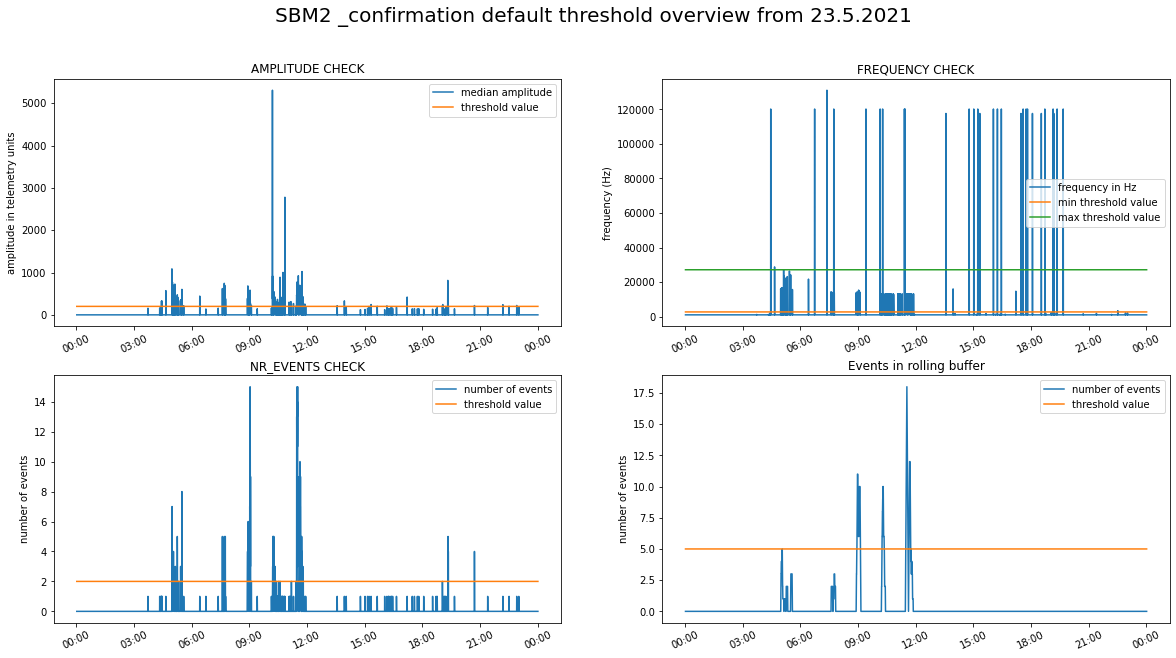

In [6]:
# Example
plot(2021, 5, 23, condef)

Directory  Single day plots/20210523/  already exists
Directory  Single day plots/20210523/  already exists
Directory  Single day plots/20210522/  already exists
Directory  Single day plots/20210522/  already exists
Directory  Single day plots/20201209/  already exists
Directory  Single day plots/20201209/  already exists
Directory  Single day plots/20201210/  already exists
Directory  Single day plots/20201210/  already exists
Directory  Single day plots/20201211/  already exists
Directory  Single day plots/20201211/  already exists
Directory  Single day plots/20201212/  already exists
Directory  Single day plots/20201212/  already exists
Directory  Single day plots/20201213/  already exists
Directory  Single day plots/20201213/  already exists
Directory  Single day plots/20210509/  already exists
Directory  Single day plots/20210509/  already exists
Directory  Single day plots/20201117/  already exists
Directory  Single day plots/20201117/  already exists
Directory  Single day plots/

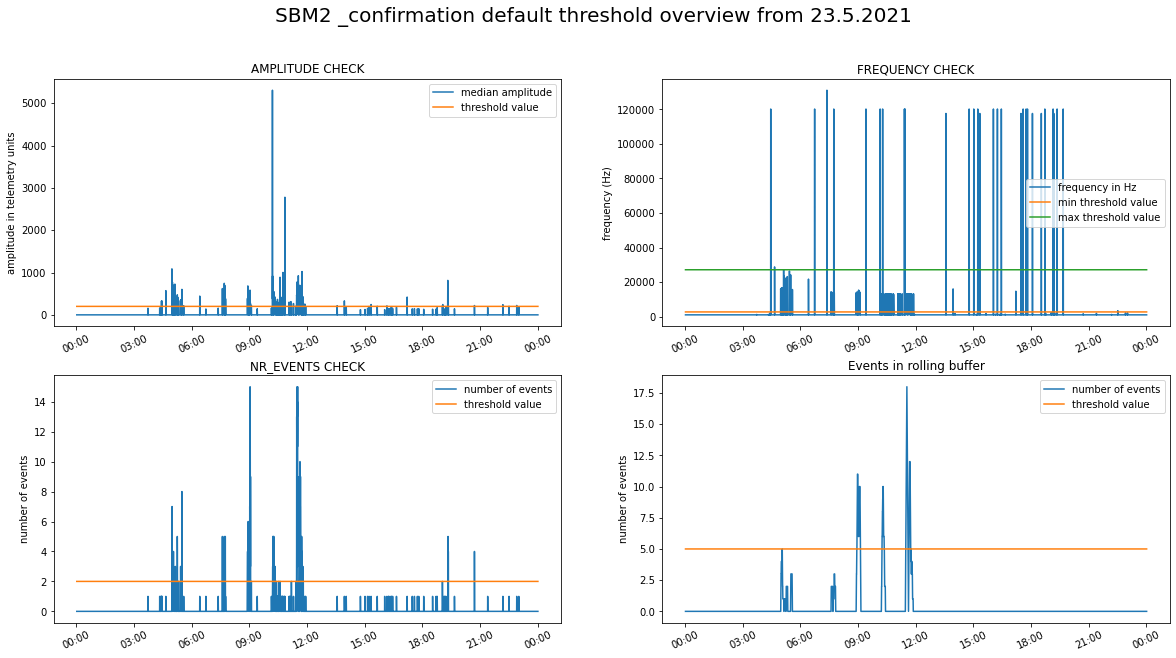

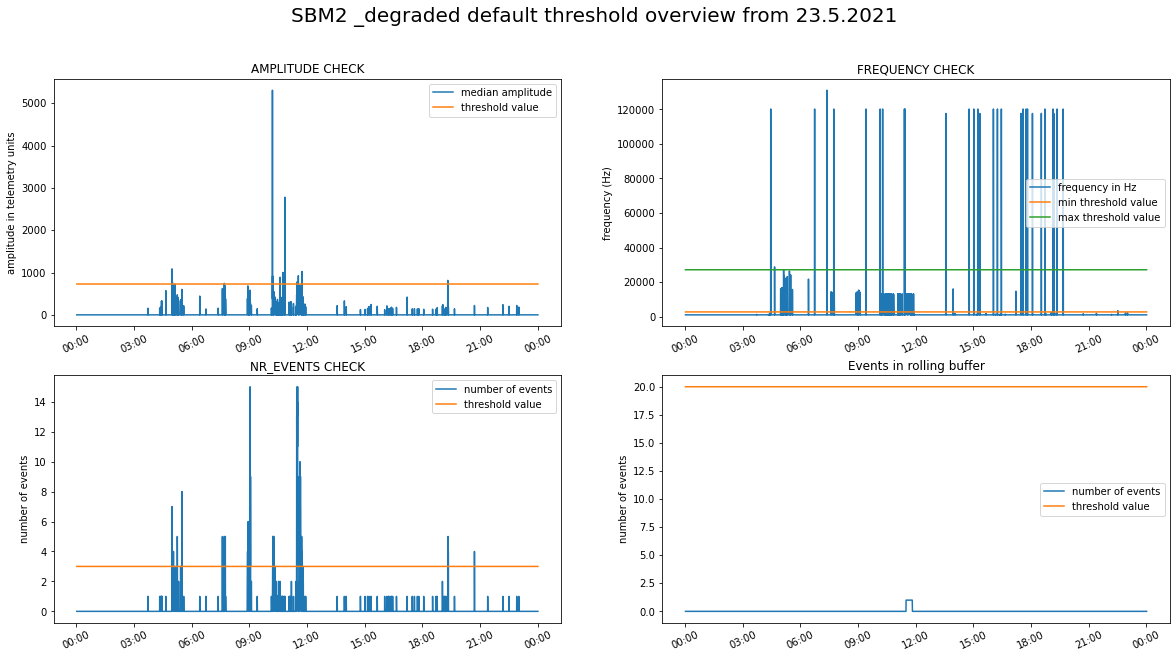

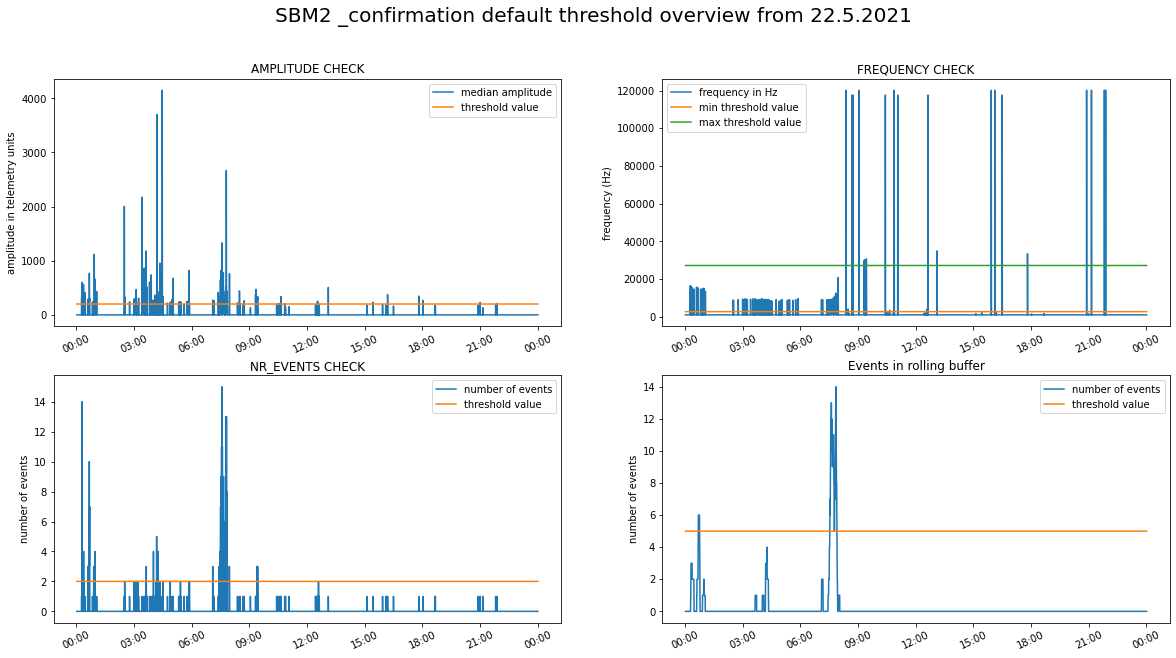

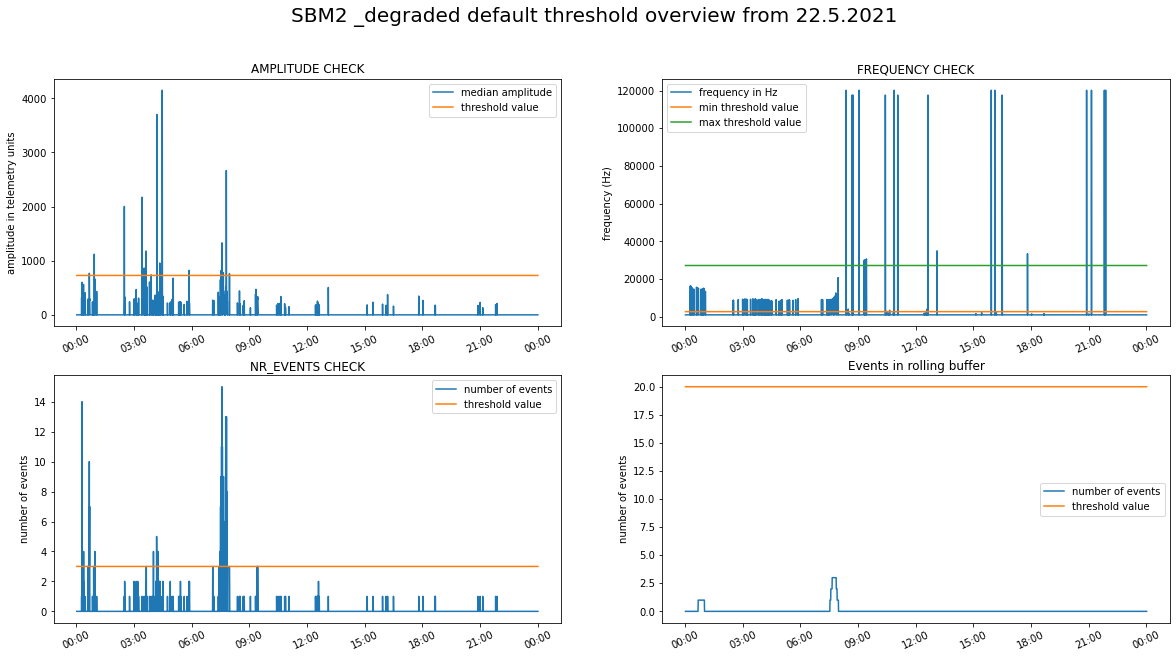

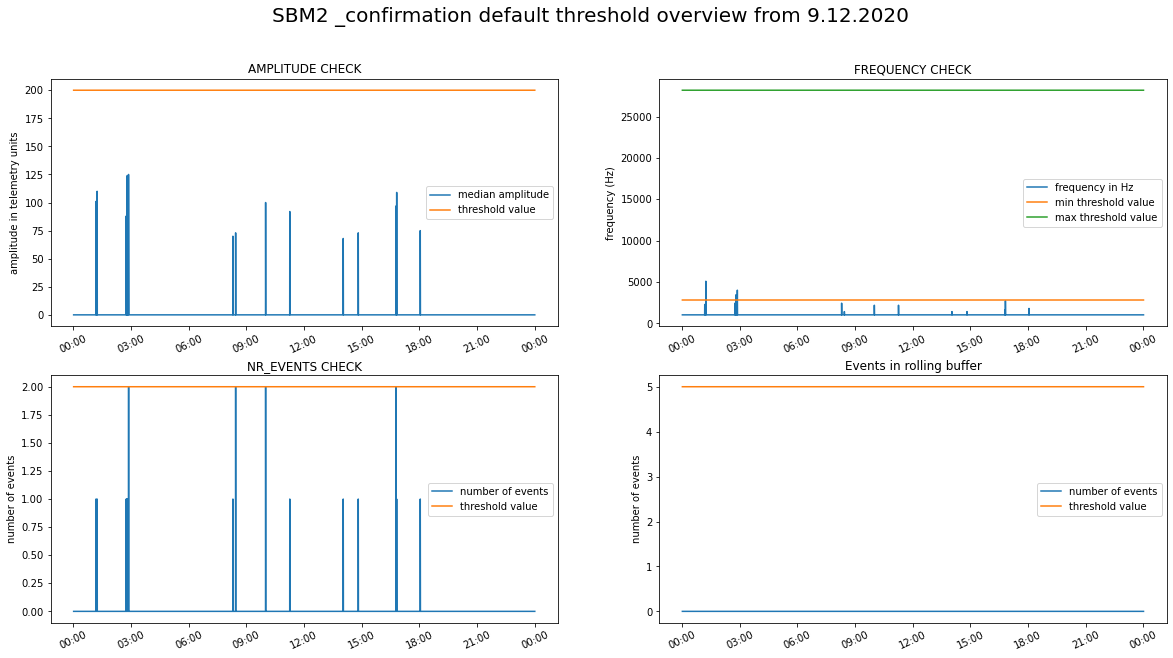

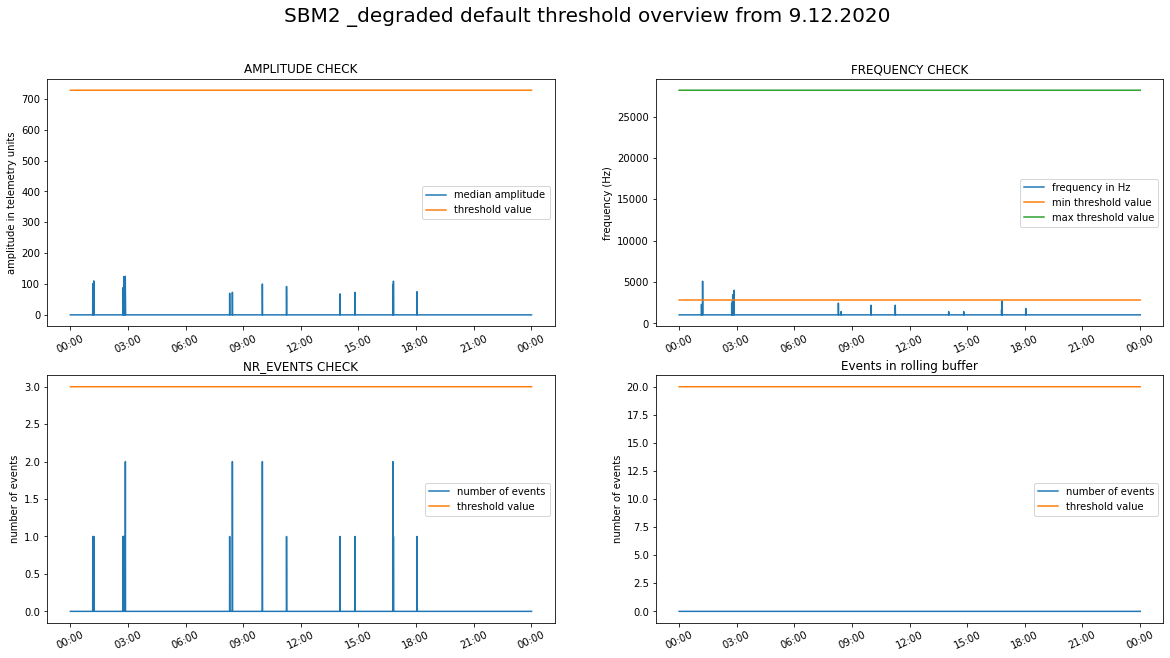

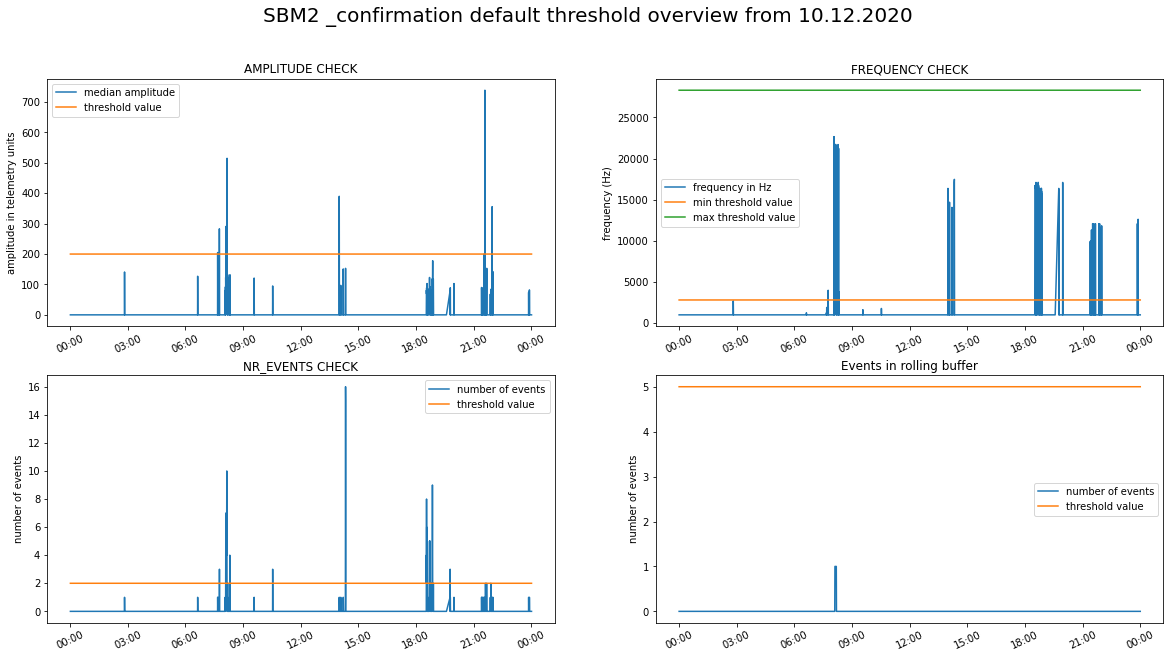

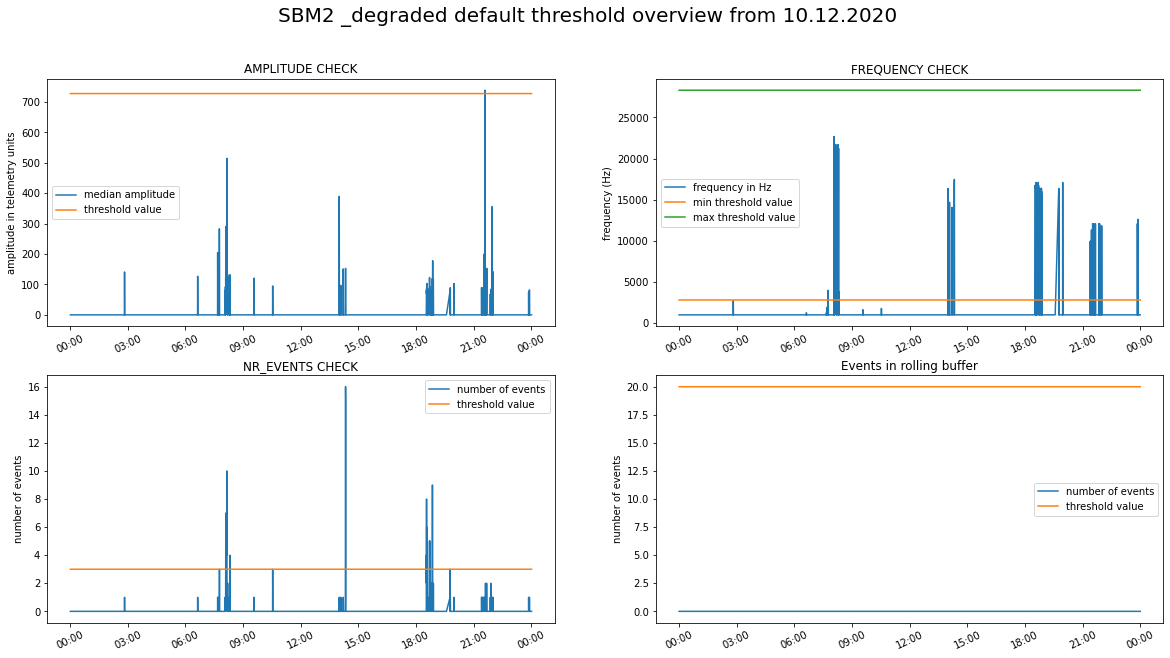

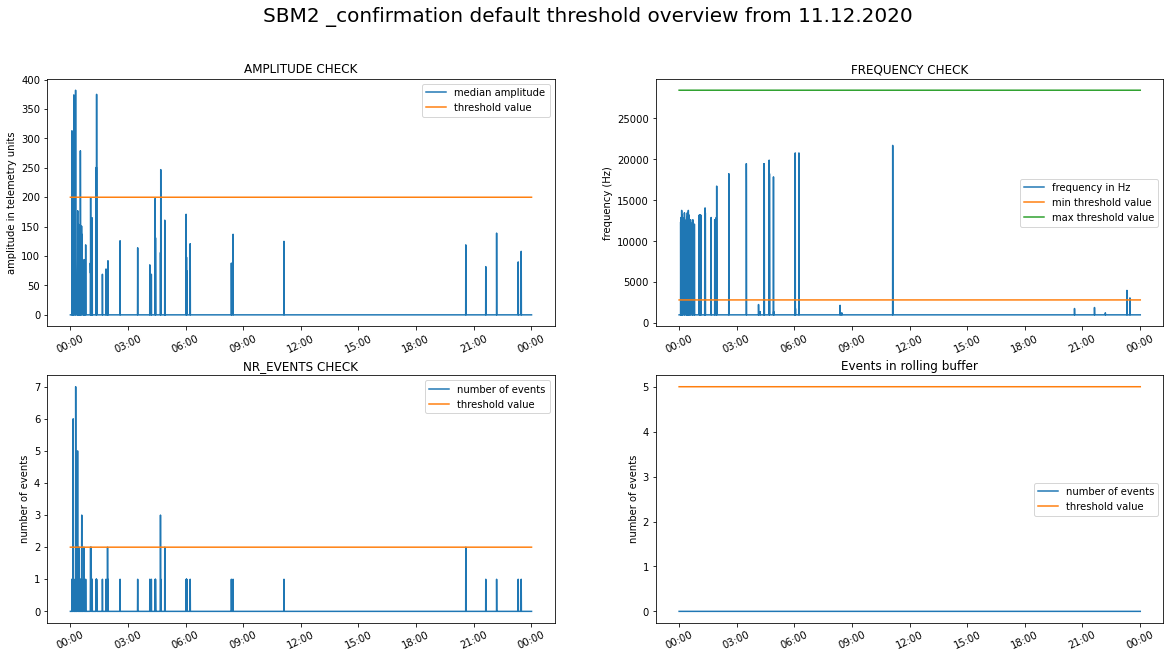

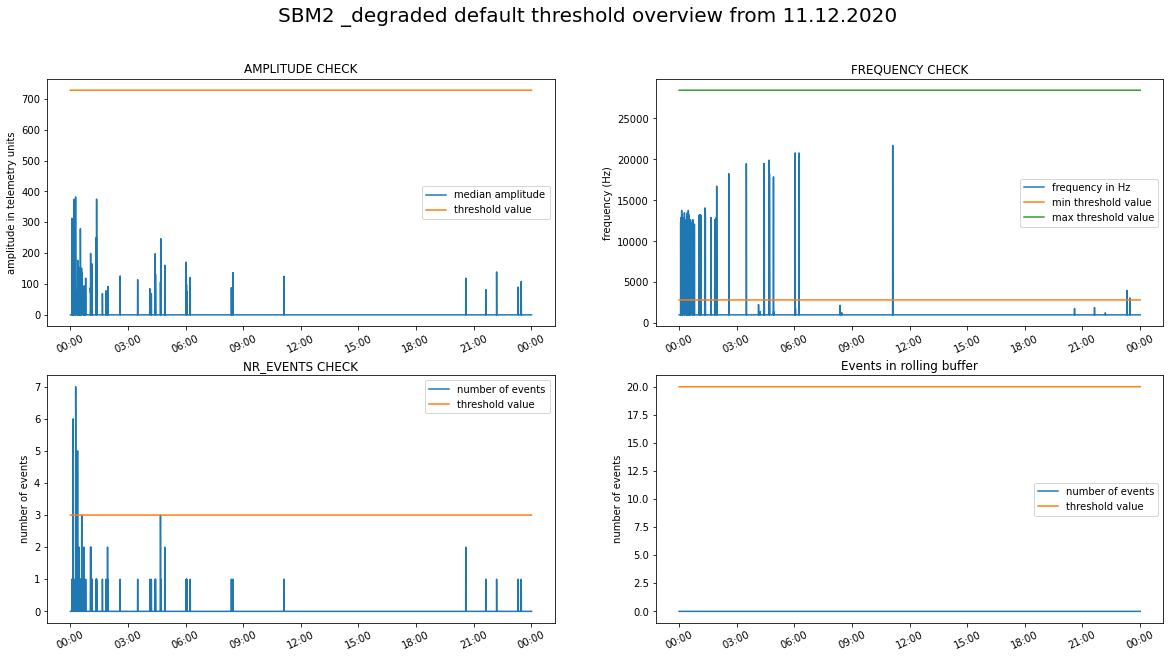

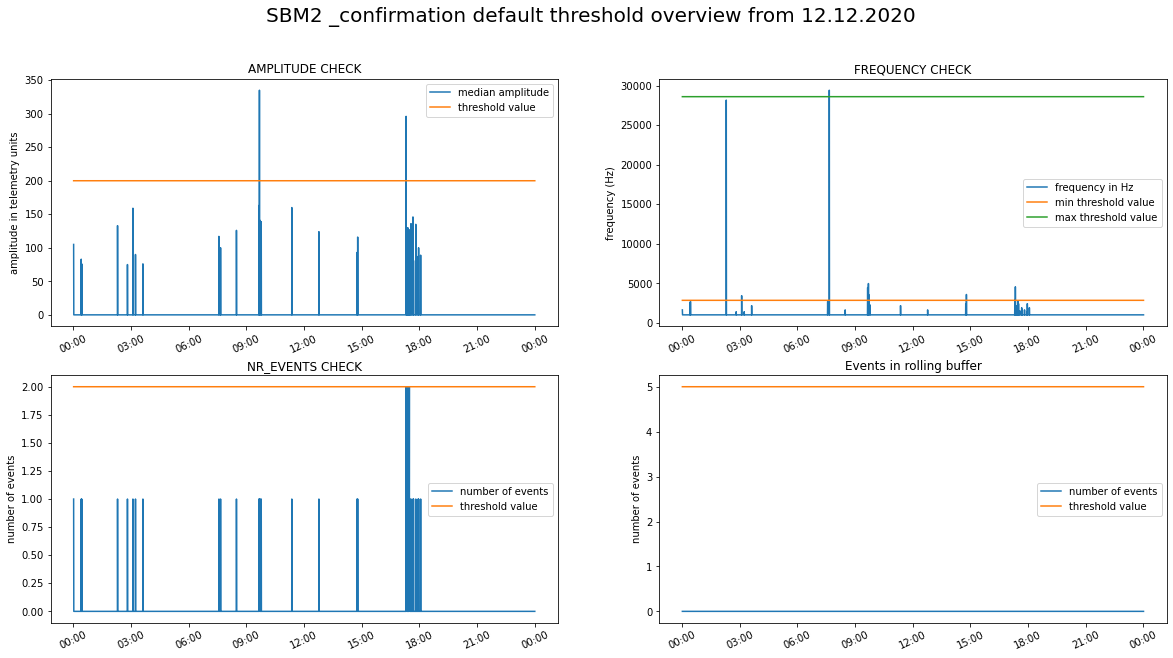

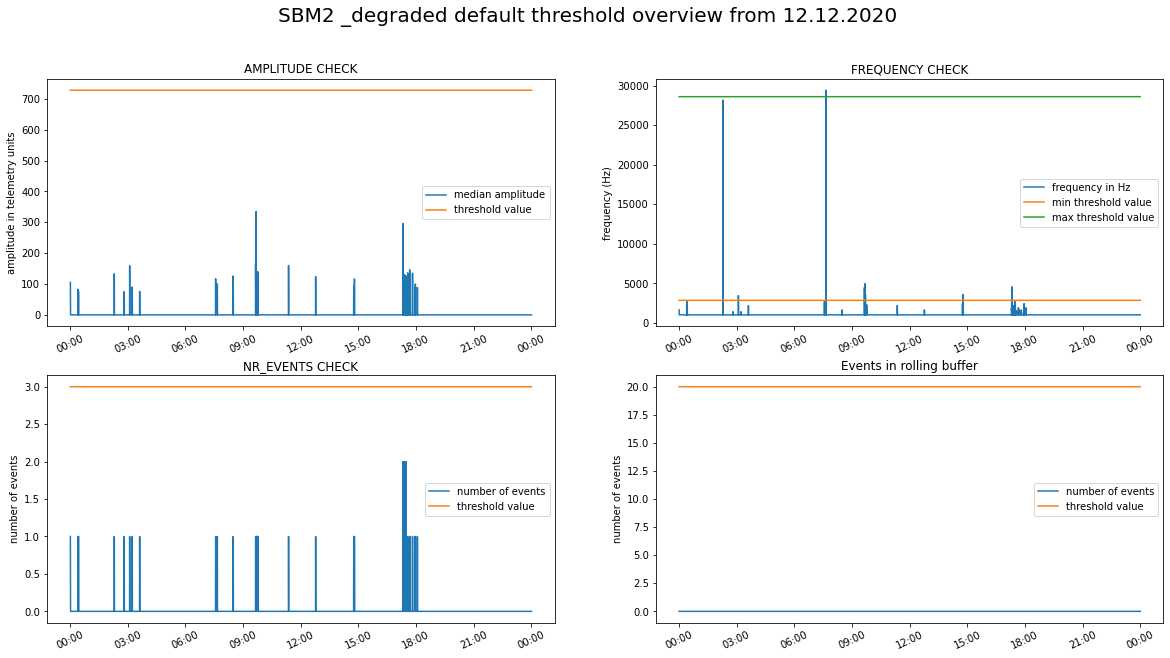

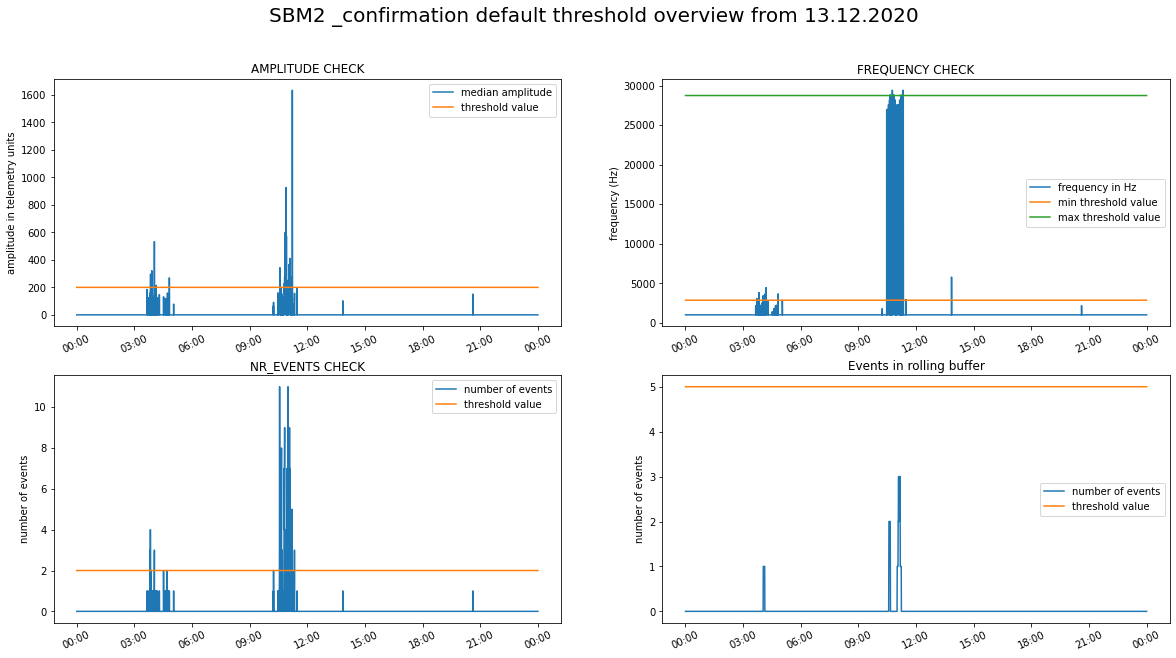

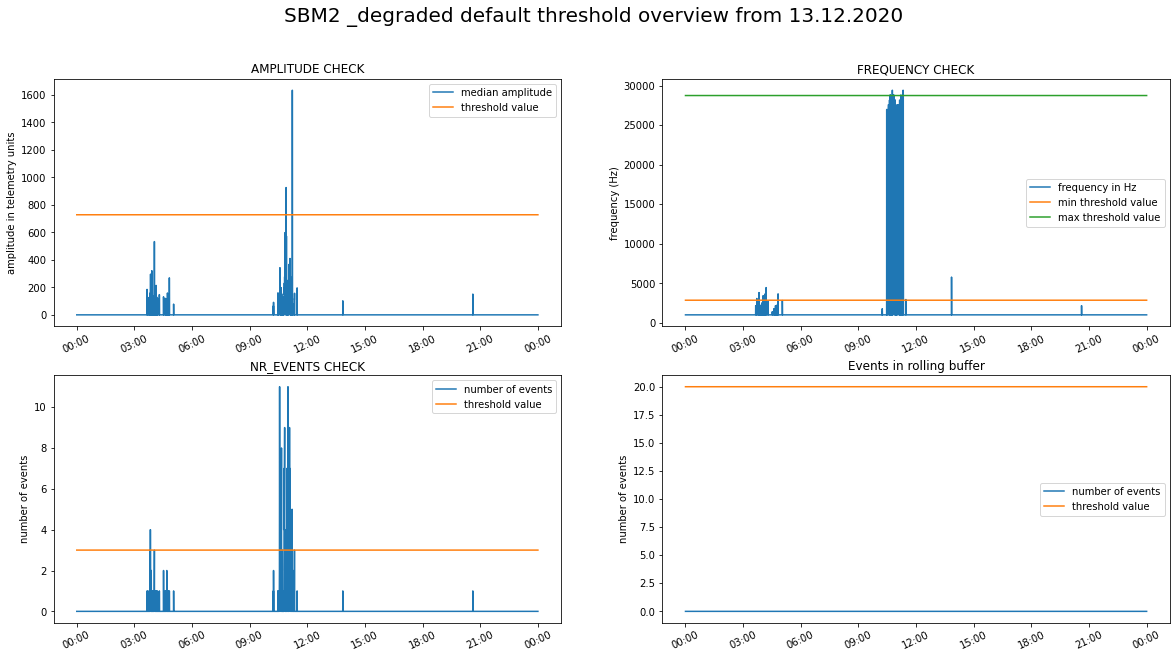

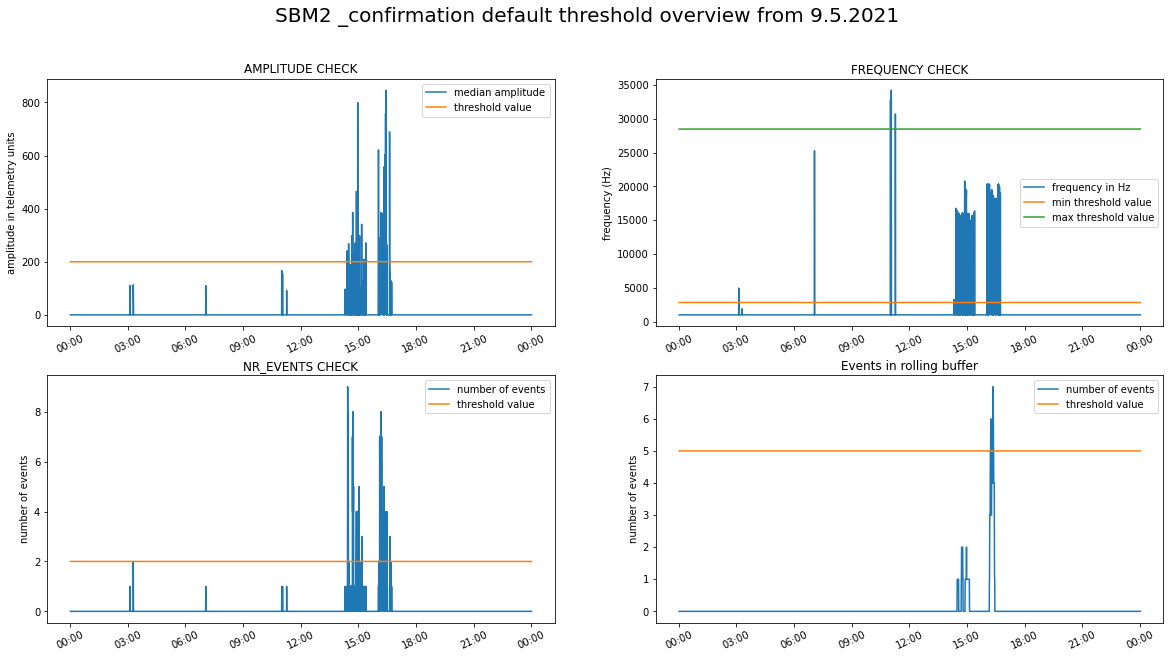

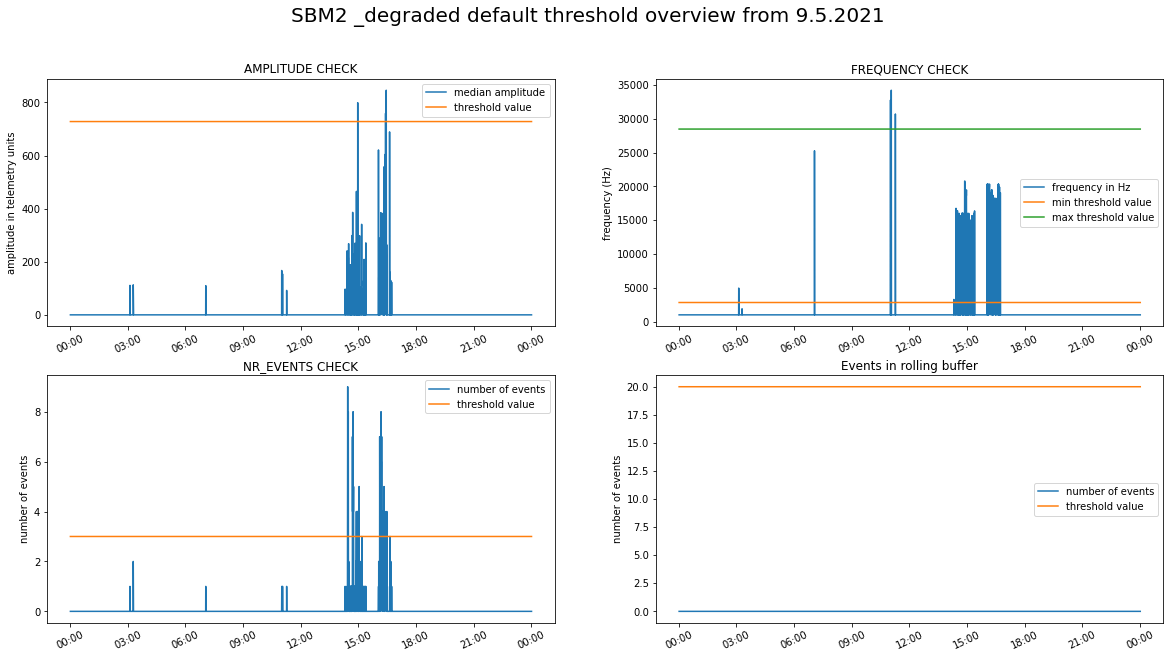

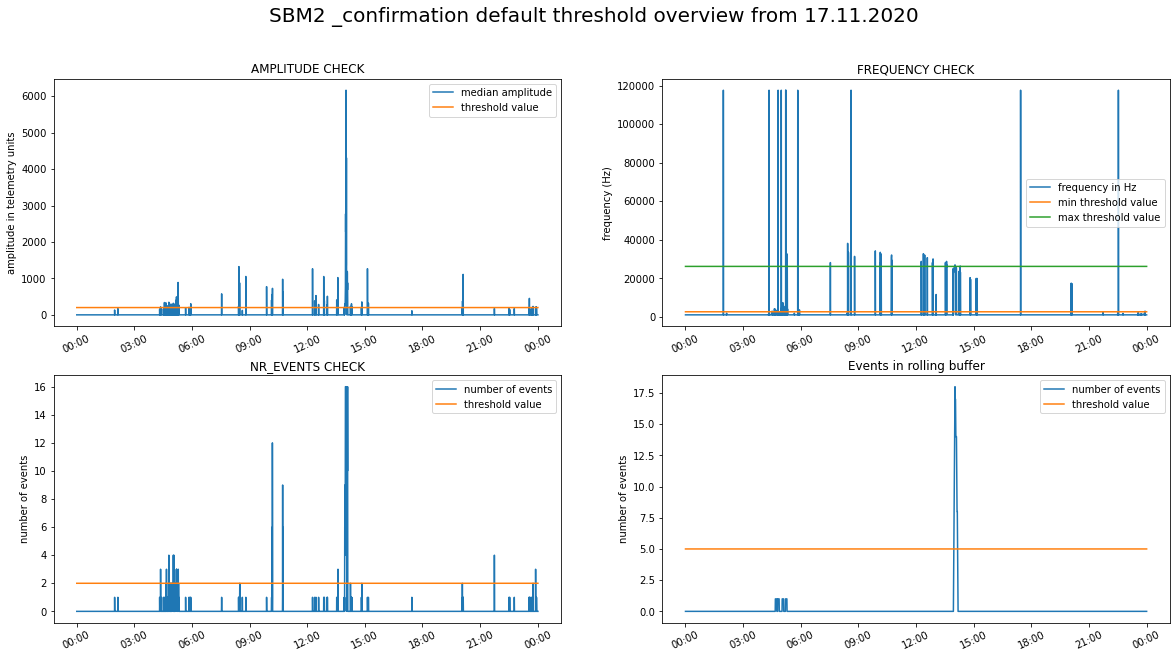

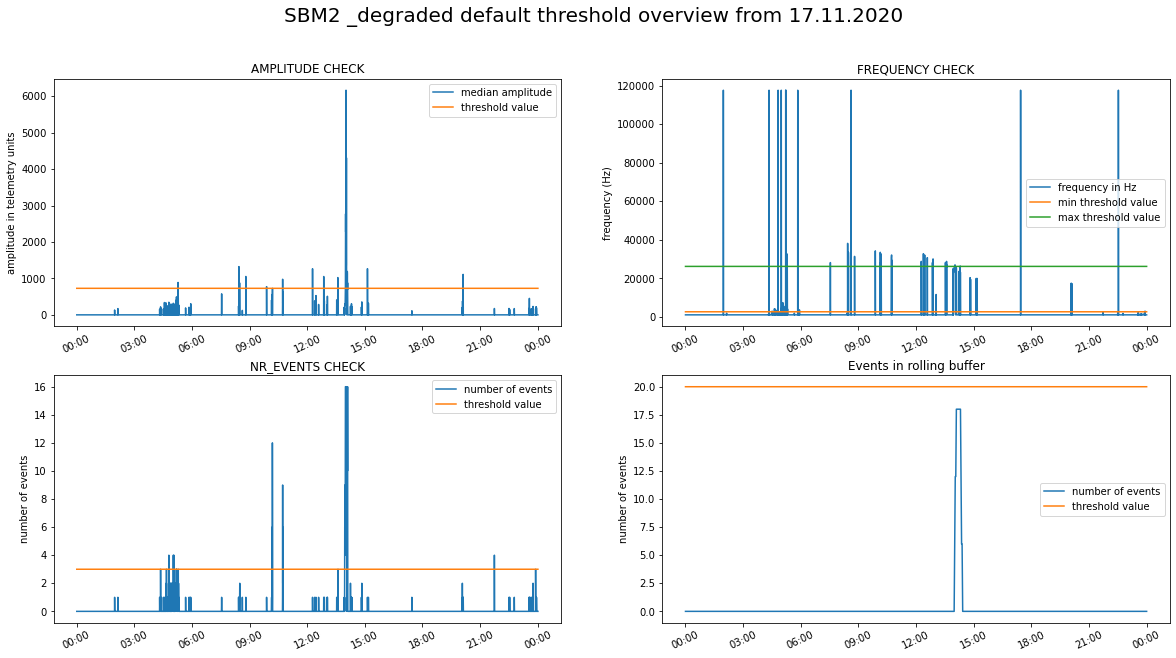

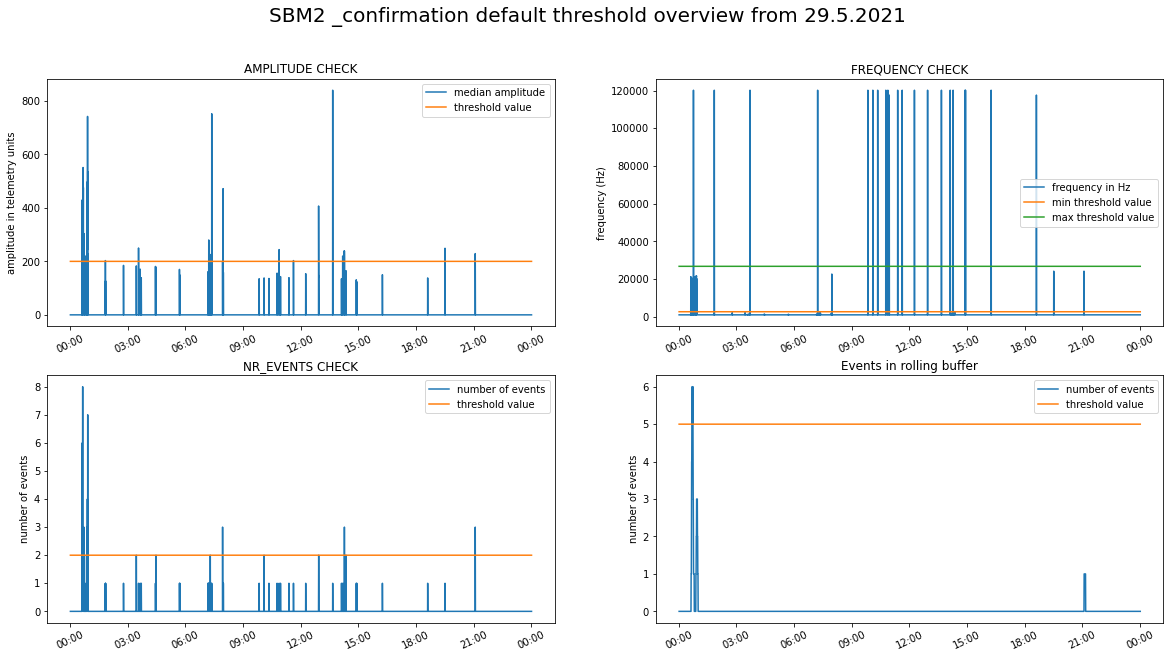

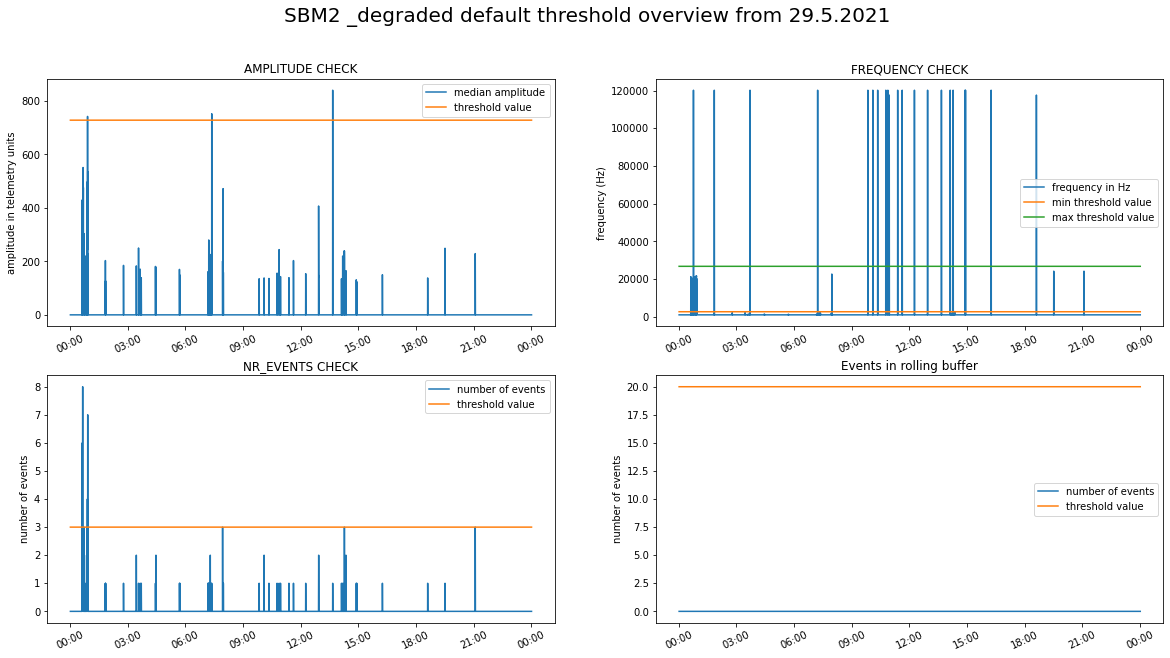

In [7]:
# Defaults
plot(2021,  5, 23, condef)
plot(2021,  5, 23, degdef)
plot(2021,  5, 22, condef)
plot(2021,  5, 22, degdef)
plot(2020, 12,  9, condef)
plot(2020, 12,  9, degdef)
plot(2020, 12, 10, condef)
plot(2020, 12, 10, degdef)
plot(2020, 12, 11, condef)
plot(2020, 12, 11, degdef)
plot(2020, 12, 12, condef)
plot(2020, 12, 12, degdef)
plot(2020, 12, 13, condef)
plot(2020, 12, 13, degdef)
plot(2021,  5,  9, condef)
plot(2021,  5,  9, degdef)
plot(2020, 11, 17, condef)
plot(2020, 11, 17, degdef)
plot(2021,  5, 29, condef)
plot(2021,  5, 29, degdef)


Directory  Single day plots/20210523/  already exists
Directory  Single day plots/20210522/  already exists
Directory  Single day plots/20201209/  already exists
Directory  Single day plots/20201210/  already exists
Directory  Single day plots/20201211/  already exists
Directory  Single day plots/20201212/  already exists
Directory  Single day plots/20201213/  already exists
Directory  Single day plots/20210509/  already exists
Directory  Single day plots/20201117/  already exists
Directory  Single day plots/20210529/  already exists


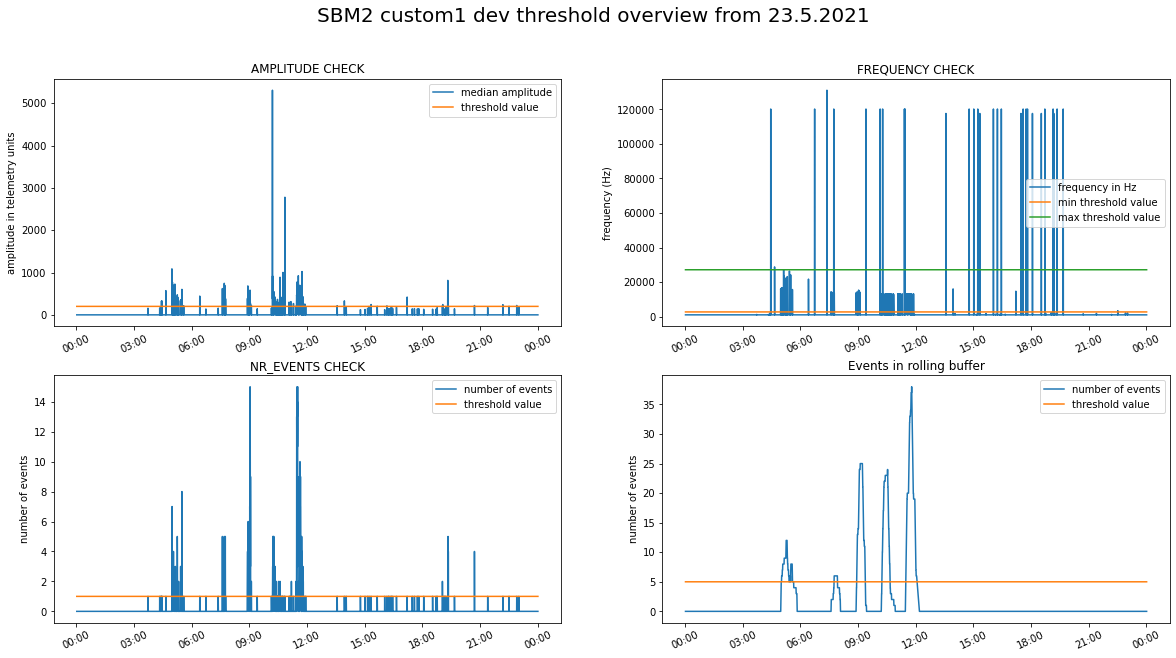

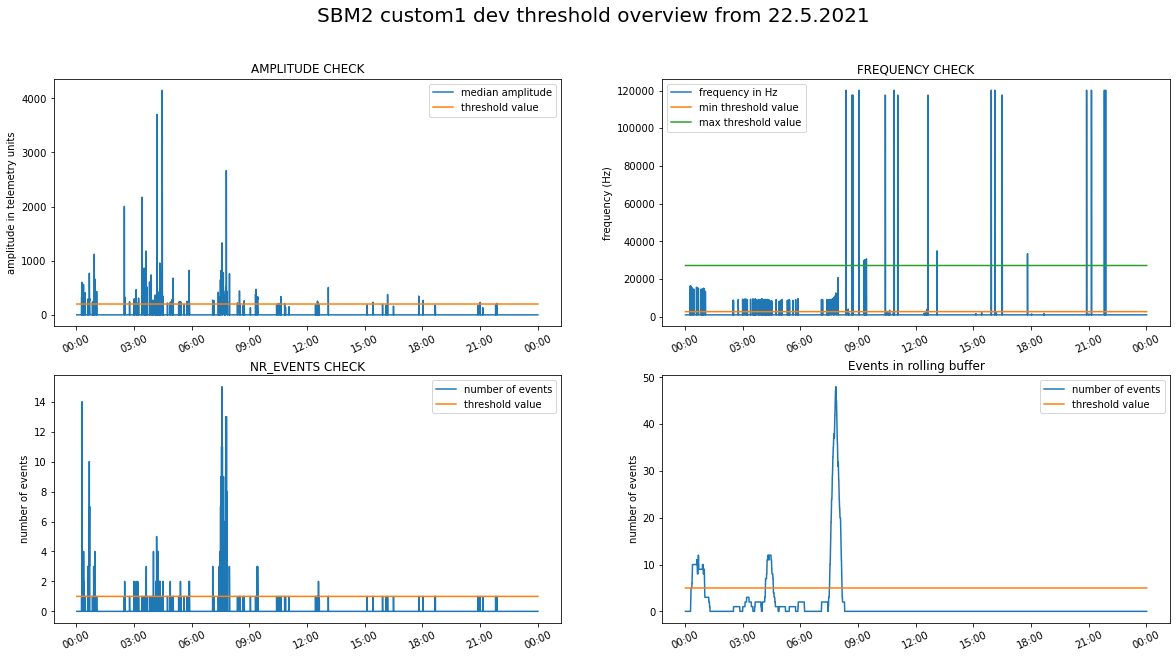

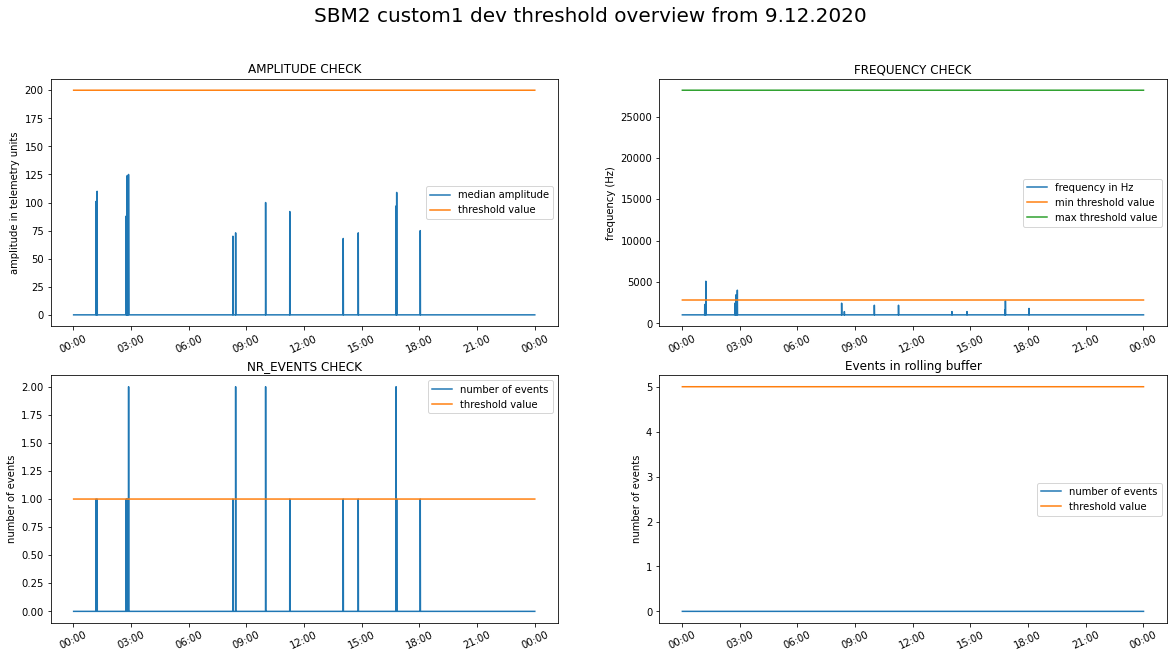

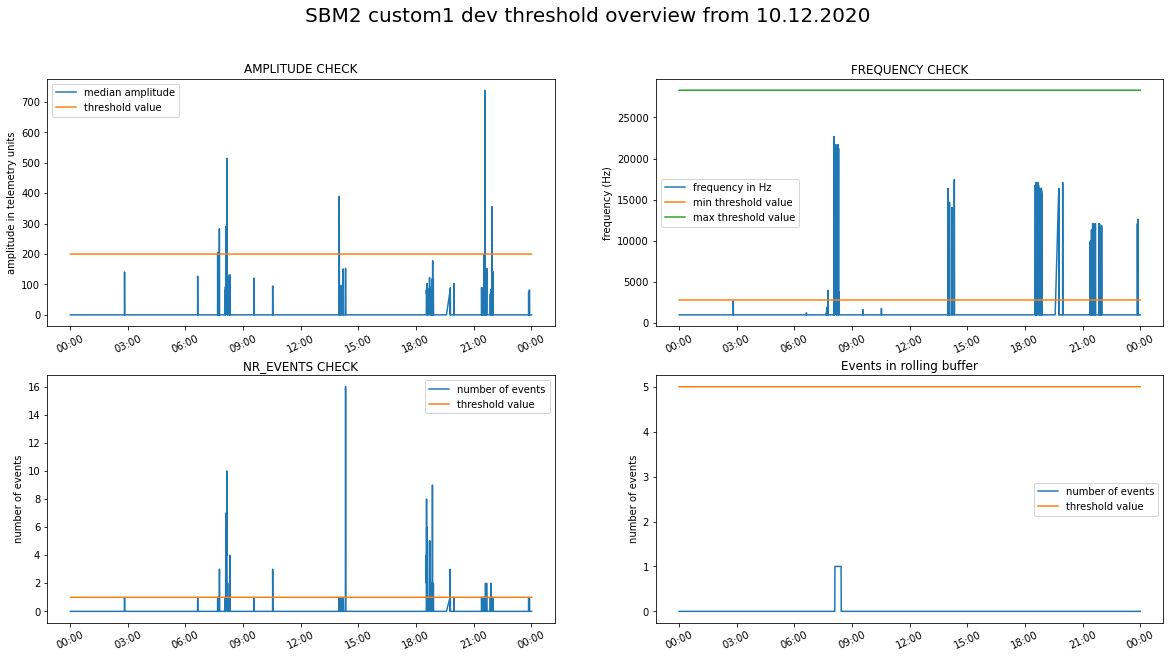

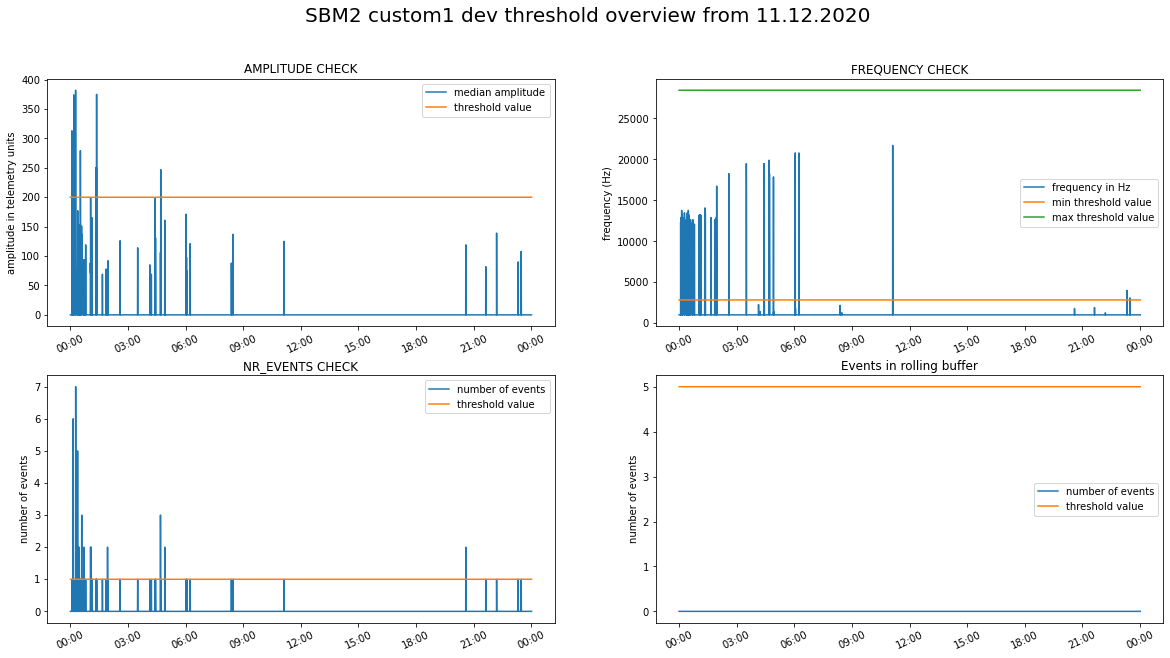

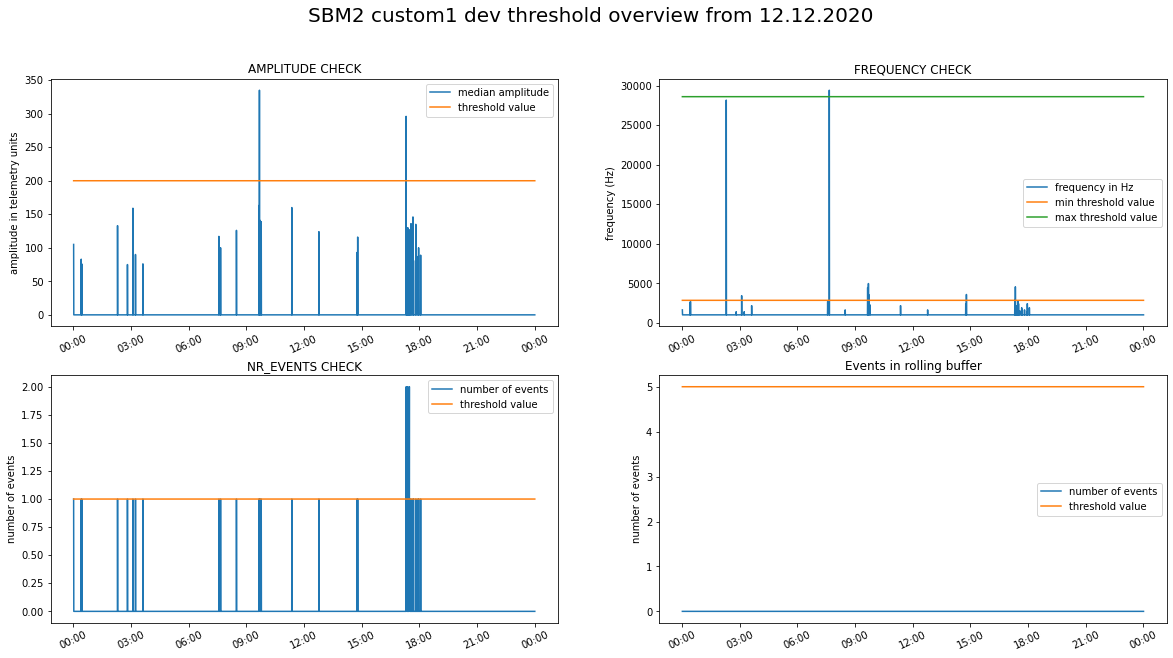

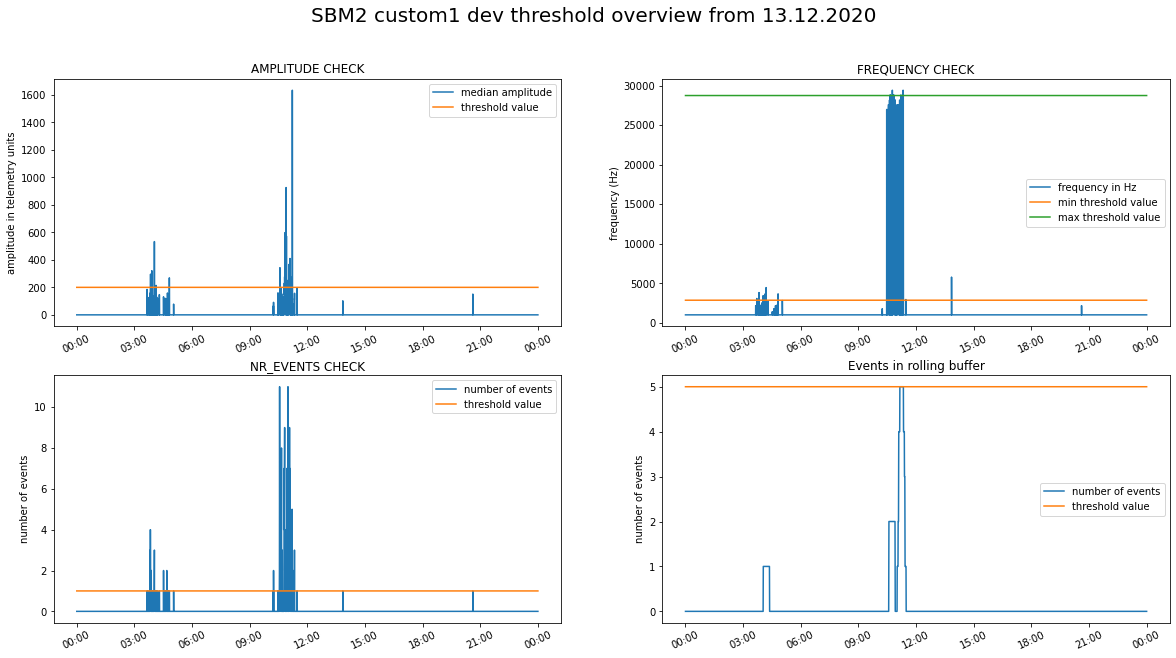

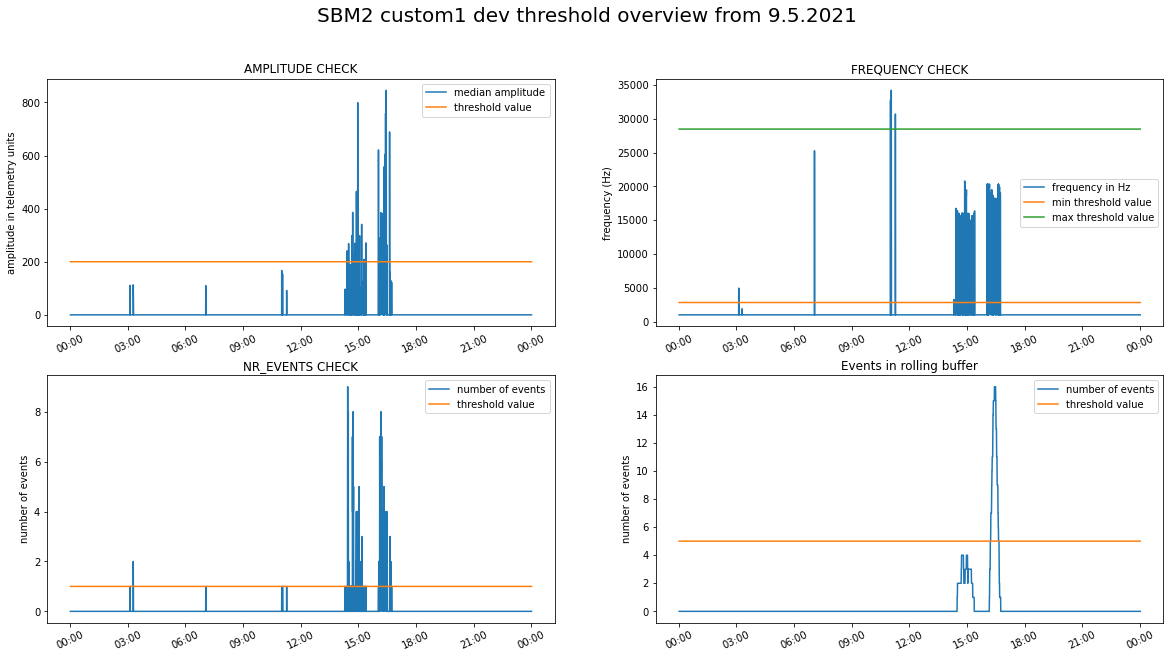

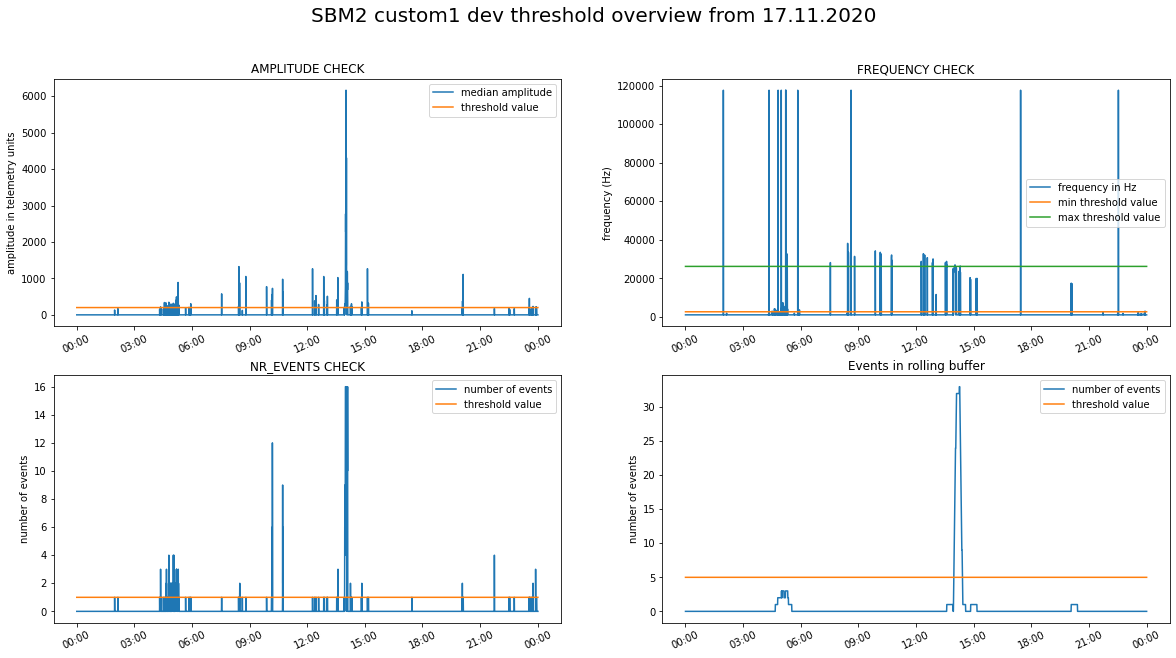

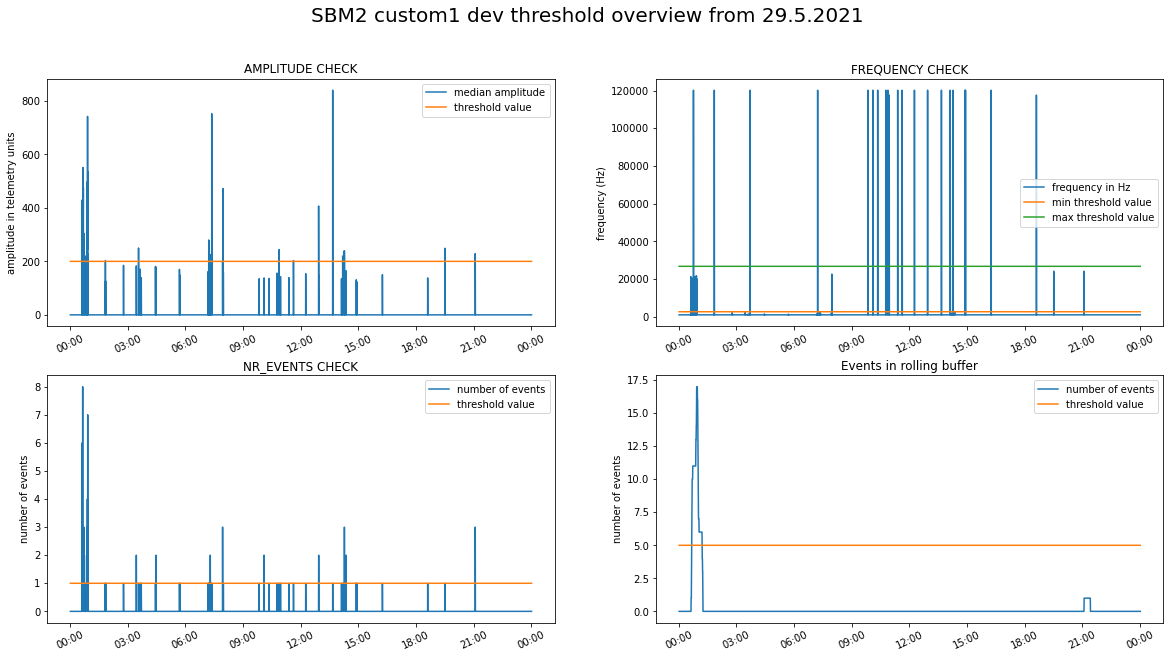

In [8]:
# Custom 1 
plot(2021,  5, 23, custom1)
plot(2021,  5, 22, custom1)
plot(2020, 12,  9, custom1)
plot(2020, 12, 10, custom1)
plot(2020, 12, 11, custom1)
plot(2020, 12, 12, custom1)
plot(2020, 12, 13, custom1)
plot(2021,  5,  9, custom1)
plot(2020, 11, 17, custom1)
plot(2021,  5, 29, custom1)

Directory  Single day plots/20210523/  already exists
Directory  Single day plots/20210522/  already exists
Directory  Single day plots/20201209/  already exists
Directory  Single day plots/20201210/  already exists
Directory  Single day plots/20201211/  already exists
Directory  Single day plots/20201212/  already exists
Directory  Single day plots/20201213/  already exists
Directory  Single day plots/20210509/  already exists
Directory  Single day plots/20201117/  already exists
Directory  Single day plots/20210529/  already exists


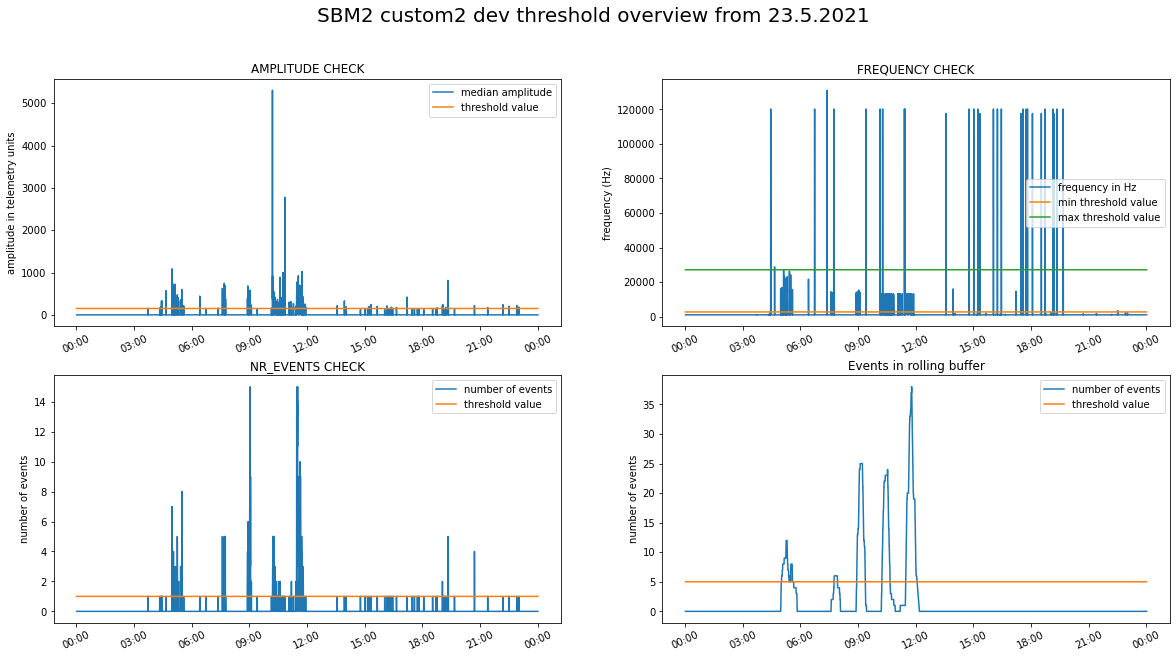

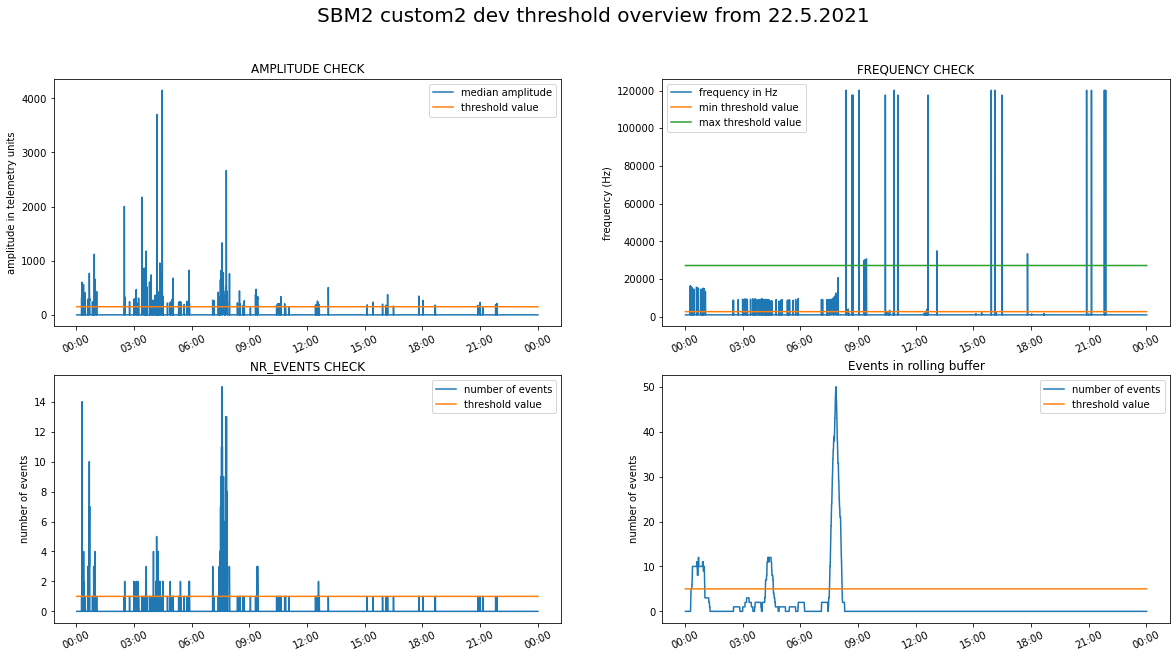

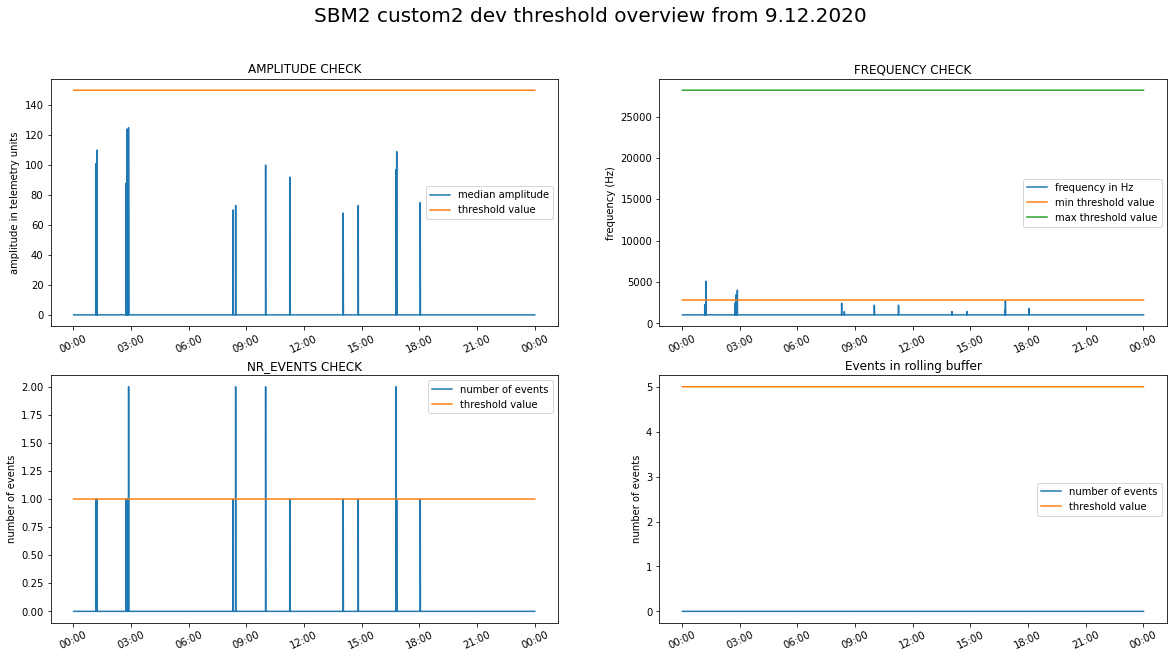

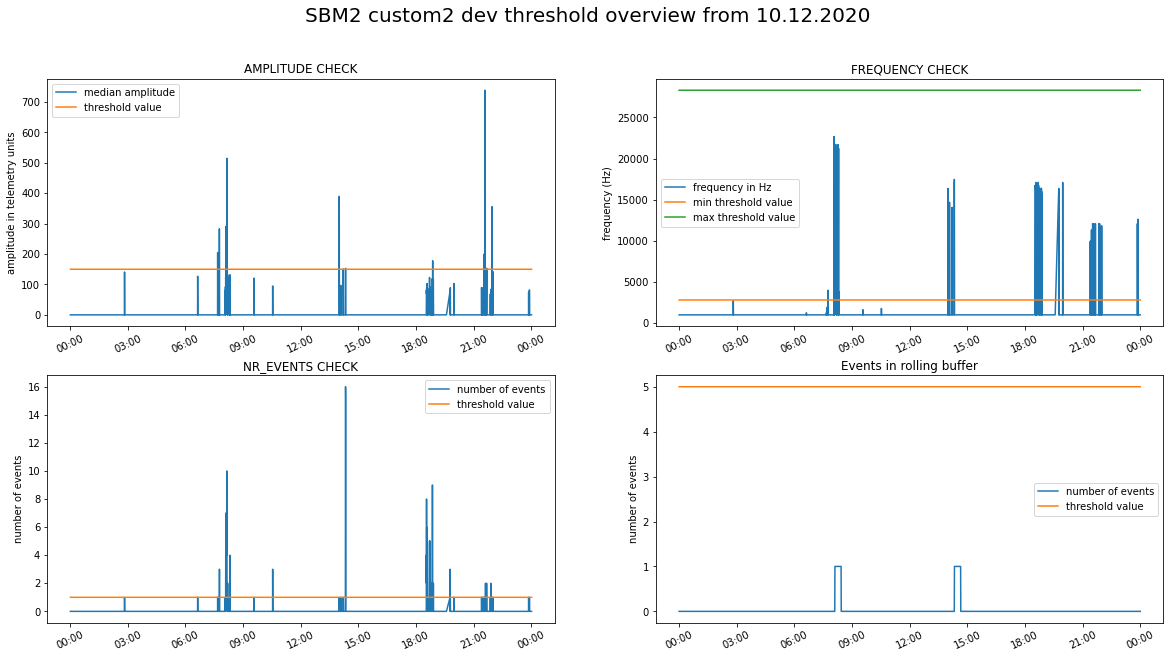

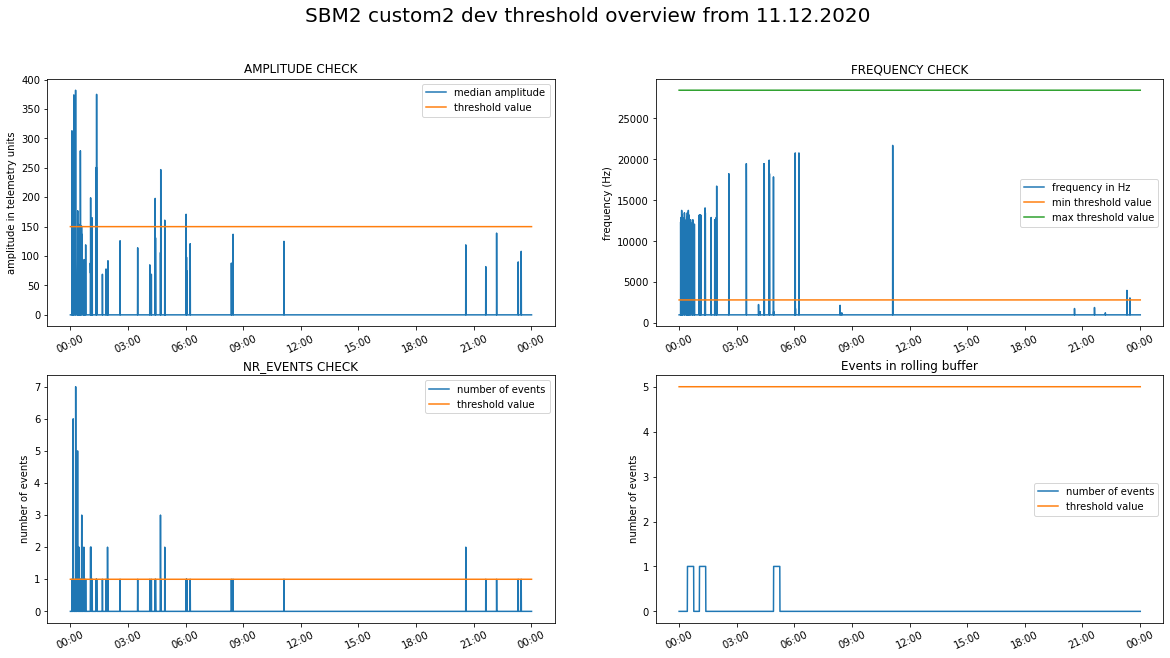

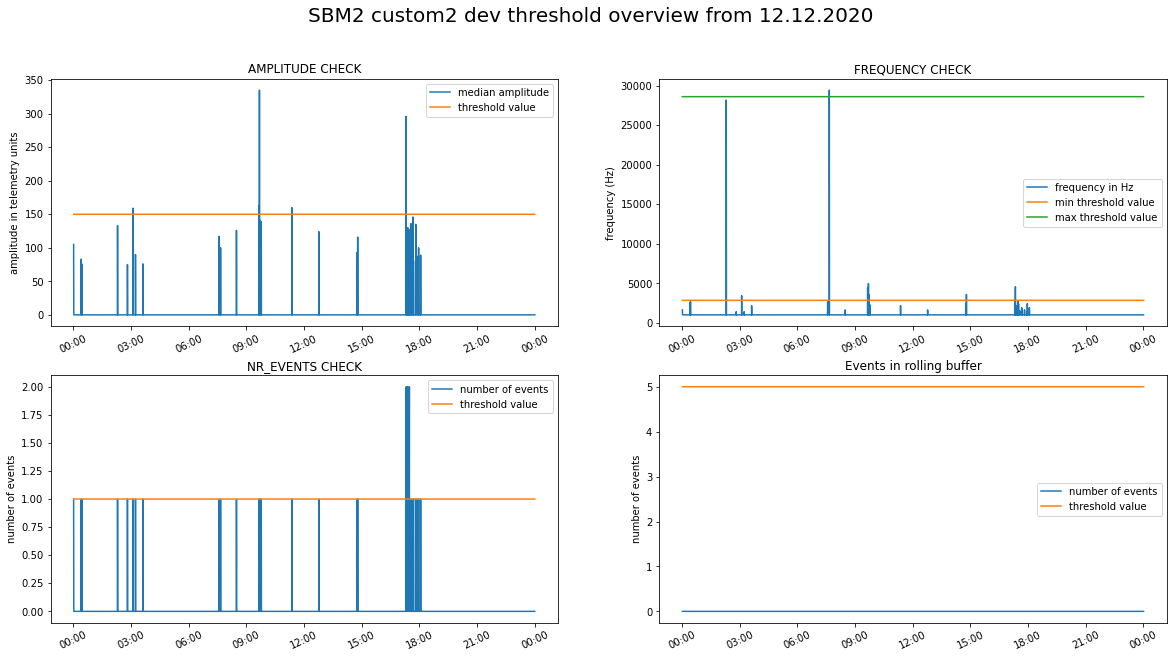

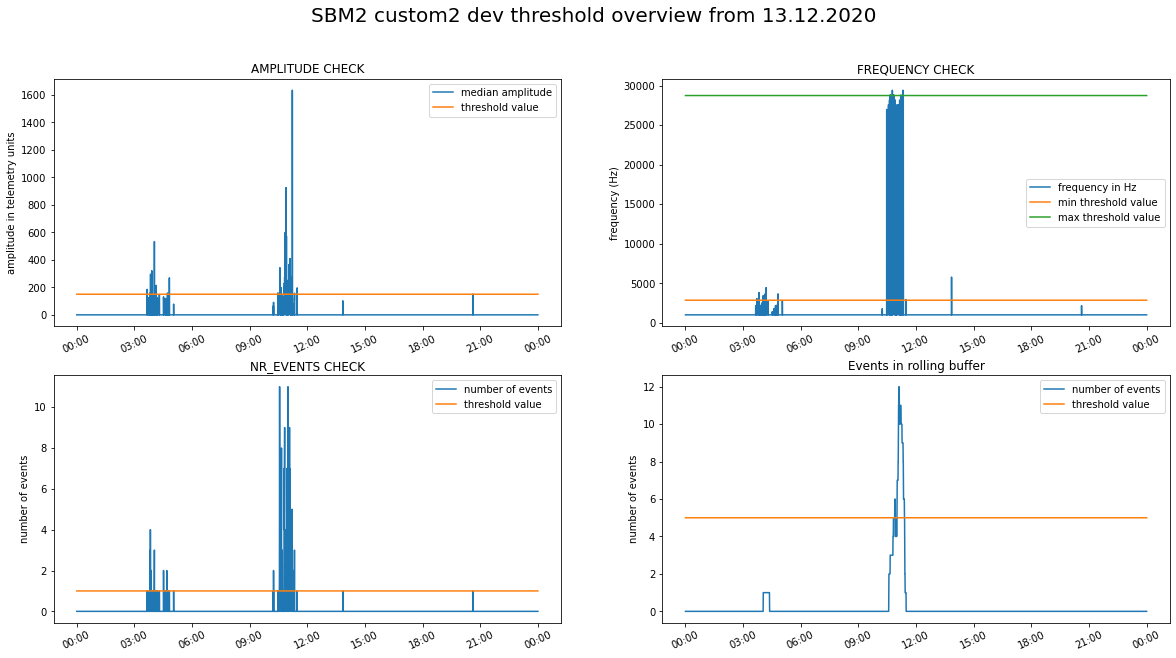

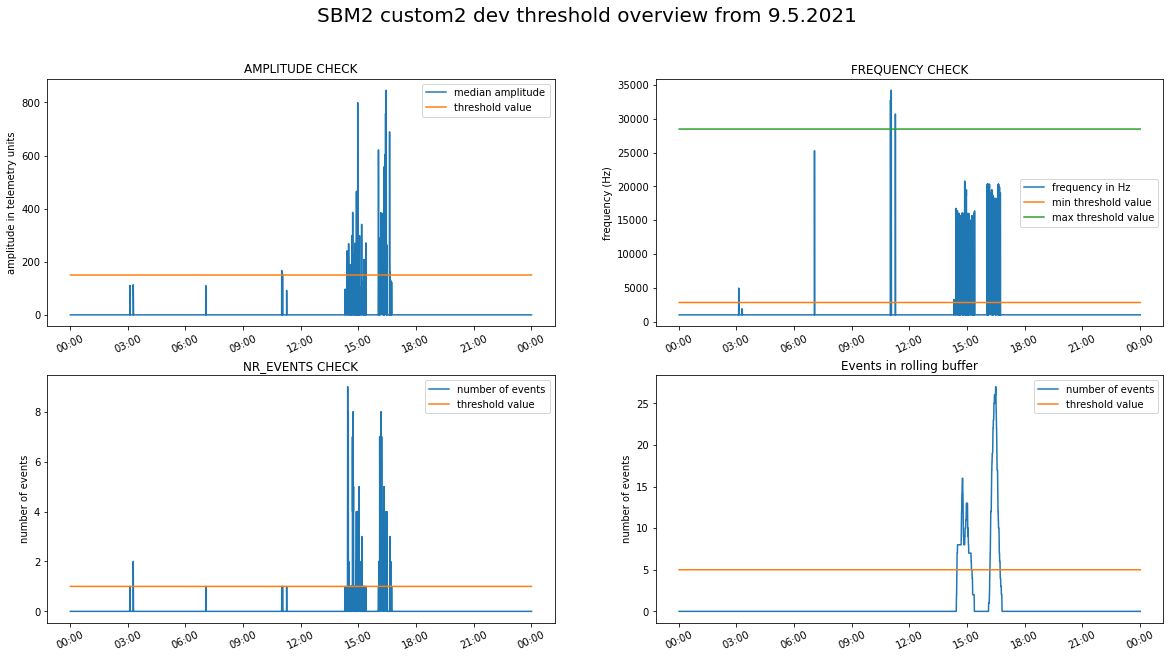

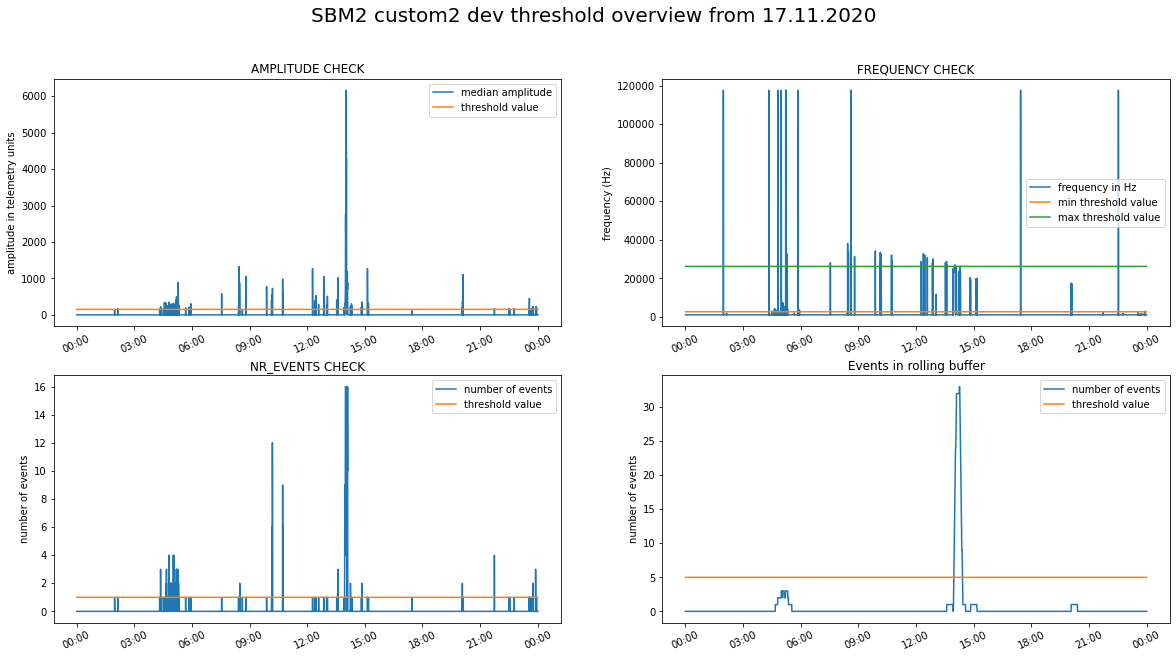

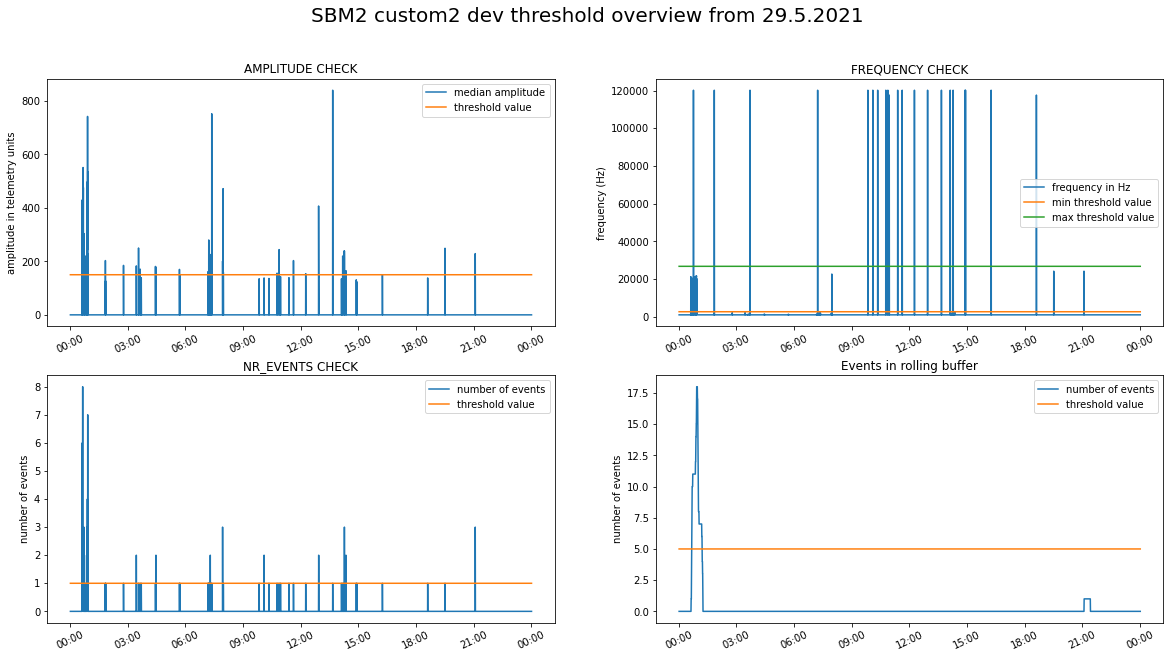

In [9]:
# Custom 2
plot(2021,  5, 23, custom2)
plot(2021,  5, 22, custom2)
plot(2020, 12,  9, custom2)
plot(2020, 12, 10, custom2)
plot(2020, 12, 11, custom2)
plot(2020, 12, 12, custom2)
plot(2020, 12, 13, custom2)
plot(2021,  5,  9, custom2)
plot(2020, 11, 17, custom2)
plot(2021,  5, 29, custom2)

Directory  Single day plots/20210203/  already exists


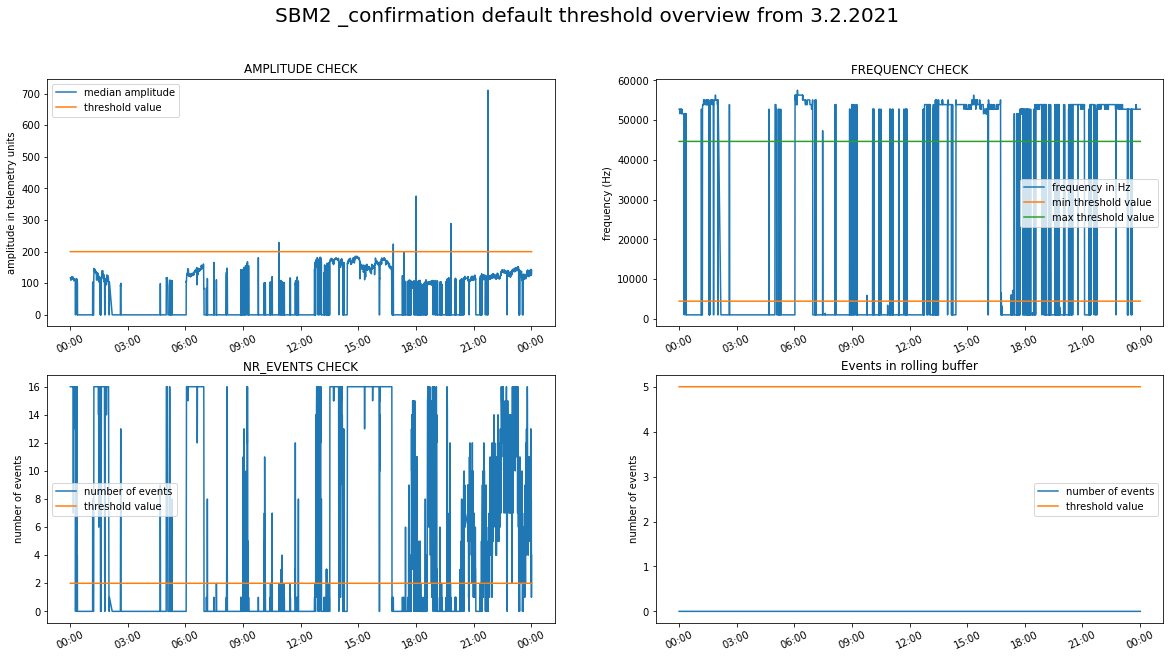

In [10]:
plot(2021, 2, 3, condef)